<a href="https://colab.research.google.com/github/jamesgolden1/equivalent-linear-LLMs/blob/main/notebooks/gemma_3/gemma_4B_jax_float32_lanczos_Borges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
pwd

'/content'

In [ ]:
try:
    from gemma import gm
except:
    !uv pip install --system -q gemma==3.1.0
    # !pip install -q gemma==3.1.0 -q
    # !pip install -q gemma==3.1.0 --target '/content/' -q

In [ ]:
!python --version

Python 3.11.13


In [ ]:
#@title Gemma Layers
# %%writefile /content/gemma/layers.py
%%writefile /usr/local/lib/python3.11/dist-packages/gemma/gm/nn/_layers.py
# Copyright 2025 DeepMind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Base layers."""

from flax import linen as nn
import jax
import jax.numpy as jnp


class Einsum(nn.Module):
  """Einsum is a convenience module for parameterized tensor multiplication."""

  shape: tuple[int, ...]
  weight_name: str = 'w'
  initializer: nn.initializers.Initializer = nn.initializers.normal()
  dtype: jnp.dtype | None = None

  @nn.compact
  def __call__(self, eqn: str, x: jax.Array) -> jax.Array:
    w = self.param(
        self.weight_name,
        self.initializer,
        self.shape,
        self.dtype if self.dtype is not None else None,
    )
    return jnp.einsum(eqn, x, w)


class RMSNorm(nn.Module):
  """RMSNorm layer."""

  @nn.compact
  def __call__(self, x):
    scale = self.param('scale', nn.initializers.zeros_init(), (x.shape[-1]))
    var = jnp.mean(jnp.square(x), axis=-1, keepdims=True)

    # Jax.lax.rsqrt is used because it returns different floats than
    # jnp.reciprocal(jnp.sqrt(var + 1e-06))


    normed_inputs = x * jax.lax.stop_gradient(jax.lax.rsqrt(var + 1e-06))

    # normed_inputs is a rank-K tensor, K > 1 (K is typically 2 or 3). scale is
    # a rank-1 tensor. To avoid implicit rank-promotion, reshape scale to
    # a (1, ..., 1, D) tensor, so the rank of scale matches normed_inputs.
    scale = jax.lax.stop_gradient(jnp.expand_dims(scale, axis=range(len(x.shape) - 1)))

    # normed_inputs = x * jax.lax.rsqrt(var + 1e-06)

    # # normed_inputs is a rank-K tensor, K > 1 (K is typically 2 or 3). scale is
    # # a rank-1 tensor. To avoid implicit rank-promotion, reshape scale to
    # # a (1, ..., 1, D) tensor, so the rank of scale matches normed_inputs.
    # scale = jnp.expand_dims(scale, axis=range(len(x.shape) - 1))

    normed_inputs = normed_inputs * (1 + scale)
    return normed_inputs


Overwriting /usr/local/lib/python3.11/dist-packages/gemma/gm/nn/_layers.py


In [ ]:
#@title Gemma Modules
# %%writefile /content/gemma/modules.py
%%writefile /usr/local/lib/python3.11/dist-packages/gemma/gm/nn/_modules.py
# Copyright 2025 DeepMind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Transformer sub-modules."""

import enum
from flax import linen as nn
from gemma.gm.math import _positional_embeddings
from gemma.gm.nn import _layers
import jax
from jax import Array
import jax.numpy as jnp

K_MASK = -2.3819763e38  # Set to a large negative number.
DEFAULT_ROPE_BASE_FREQUENCY = 10_000
DEFAULT_ROPE_SCALE_FACTOR = 1.0

# A dictionary with the following array shapes as keys:
# v: [batch_size, cache_size, num_heads, head_dim]
# k: [batch_size, cache_size, num_heads, head_dim]
# end_index: [batch_size]
LayerCache = dict[str, jax.Array]


def _create_sliding_mask(
    segment_pos: jnp.ndarray,
    end_index: int,
    cache_len: int,
    sliding_window_size: int,
):
  """Creates mask for sliding window attention."""
  total_tokens = end_index + segment_pos.shape[1]  # cached + processing tokens

  def _reconstruct_rotated_cache_positions():
    cache_positions = jnp.arange(cache_len) + total_tokens - cache_len
    cache_positions = (
        jnp.zeros_like(cache_positions)
        # kv were placed at index (position_id % cache_len) in the cache.
        .at[cache_positions % cache_len].set(cache_positions)
    )
    return cache_positions

  # Reconstruct position_ids for cached kv.
  cache_positions = jax.lax.cond(
      total_tokens <= cache_len,
      lambda: jnp.arange(cache_len),
      _reconstruct_rotated_cache_positions,
  )

  cache_positions = cache_positions[None, None, :]  # [1, 1, cache_len]
  segment_pos = segment_pos[:, :, None]  # [B, seq_len, 1]
  sliding_mask = cache_positions > segment_pos - sliding_window_size
  sliding_mask *= cache_positions < segment_pos + sliding_window_size
  return sliding_mask


class AttentionType(enum.Enum):
  GLOBAL = 1
  LOCAL_SLIDING = 2


class Embedder(nn.Module):
  """Embedder module."""

  vocab_size: int
  embed_dim: int

  vision_proj_dim: int | None = None

  def setup(self):
    # Embedding matrix of shape [vocab_size, embed_dim]
    self.input_embedding_table = self.param(
        'input_embedding',
        nn.initializers.normal(),
        (self.vocab_size, self.embed_dim),
    )

    # For the multi-modal models, the encoder has additional parameters:
    # * `mm_soft_embedding_norm` and `mm_input_projection`: Those weights
    #   serve to project the soft tokens from the image encoder into the
    #   embedding space of the text encoder. Those tokens are then merged with
    #   the text tokens inside `Transformer._include_vision_embeddings`.
    if self.vision_proj_dim:
      self.mm_soft_embedding_norm = _layers.RMSNorm()
      self.mm_input_projection = _layers.Einsum(
          (self.vision_proj_dim, self.embed_dim)
      )

  def encode(self, x: jax.Array) -> jax.Array:
    """Encodes the input tokens.

    Args:
      x: Input tokens of shape [seq_len] or [batch_size, seq_len], where
        each token is an integer in [0, vocab_size).

    Returns:
      Encoded tokens of shape [seq_len, embed_dim] or [batch_size, seq_len,
      embed_dim].
    """
    x = self.input_embedding_table[(x,)]
    x *= jnp.sqrt(self.embed_dim).astype(x.dtype)
    return x

  def decode(self, x: jax.Array) -> jax.Array:
    """Decodes the input vectors.

    Args:
      x: Array of shape [seq_len, embed_dim] or [batch_size, seq_len,
        embed_dim].

    Returns:
      Array of shape [seq_len, vocab_size] or [batch_size, seq_len, vocab_size].
    """
    return jnp.dot(x, self.input_embedding_table.T)

  def encode_vision(self, x: jax.Array) -> jax.Array:
    """Projects siglip embeddings to the embedding space of the text encoder."""
    x = self.mm_soft_embedding_norm(x)
    x = self.mm_input_projection('...tm,md->...td', x)
    return x


class Attention(nn.Module):
  """Attention module."""

  num_heads: int
  num_kv_heads: int
  features: int
  head_dim: int
  attn_type: AttentionType
  query_pre_attn_scalar: float
  rope_base_frequency: int = DEFAULT_ROPE_BASE_FREQUENCY
  rope_scale_factor: float = DEFAULT_ROPE_SCALE_FACTOR
  attn_logits_soft_cap: float | None = None
  sliding_window_size: int | None = None
  use_qk_norm: bool = False

  @property
  def use_qkv_einsum(self):
    return self.num_kv_heads == self.num_heads

  @property
  def use_gqa(self):
    return self.num_kv_heads != self.num_heads and self.num_kv_heads > 1

  def setup(self):
    self.attn_vec_einsum = _layers.Einsum(
        shape=(self.num_heads, self.head_dim, self.features),
    )

    if self.use_qkv_einsum:
      self.qkv_einsum = _layers.Einsum(
          shape=(3, self.num_heads, self.features, self.head_dim),
      )
    else:
      self.q_einsum = _layers.Einsum(
          shape=(self.num_heads, self.features, self.head_dim),
      )
      self.kv_einsum = _layers.Einsum(
          shape=(2, self.num_kv_heads, self.features, self.head_dim),
      )
    if self.use_qk_norm:
      self._query_norm = _layers.RMSNorm()
      self._key_norm = _layers.RMSNorm()

  def __call__(
      self,
      x: jax.Array,
      segment_pos: jax.Array,
      cache: LayerCache | None,
      attn_mask: jax.Array,
  ) -> tuple[LayerCache | None, jax.Array]:
    """Applies multi-head attention to the inputs.

    Args:
      x: Input sequence of shape [batch_size, seq_len, embed_dim].
      segment_pos: Input absolute positions of shape [batch_size, seq_len].
      cache: KV cache or None.
      attn_mask: Attention mask of shape [batch_size, seq_len, cache_size].

    Returns:
      cache: Updated attention KV cache.
      outputs: Output sequence of shape [batch_size, seq_len, embed_dim].
    """
    if self.use_qkv_einsum:
      # [batch_size, seq_len, num_heads, head_dim]
      query_proj, key_proj, value_proj = self.qkv_einsum('BTD,SNDH->SBTNH', x)
    else:
      query_proj = self.q_einsum('BTD,NDH->BTNH', x)
      key_proj, value_proj = self.kv_einsum('BSD,CKDH->CBSKH', x)

    query_proj = jax.lax.stop_gradient(query_proj)
    key_proj = jax.lax.stop_gradient(key_proj)

    if self.use_qk_norm:
      query_proj = self._query_norm(query_proj)
      key_proj = self._key_norm(key_proj)

    query_proj = _positional_embeddings.apply_rope(
        query_proj,
        segment_pos,
        base_frequency=self.rope_base_frequency,
        scale_factor=self.rope_scale_factor,
    )
    query_scaled = query_proj * self.query_pre_attn_scalar

    key_proj = _positional_embeddings.apply_rope(
        key_proj,
        segment_pos,
        base_frequency=self.rope_base_frequency,
        scale_factor=self.rope_scale_factor,
    )

    query_proj = jax.lax.stop_gradient(query_proj)
    key_proj = jax.lax.stop_gradient(key_proj)

    # Cache is left aligned.
    # Save the KV values to the cache.
    if cache is not None:
      end_index = cache['end_index'][0]
      cache_size = cache['v'].shape[1]
      slice_indices = (0, end_index % cache_size, 0, 0)

      # [batch_size, cache_size, num_heads, head_dim]
      value_proj = jax.lax.dynamic_update_slice(
          cache['v'],
          value_proj,
          slice_indices,
      )

      # [batch_size, cache_size, num_heads, head_dim]
      key_proj = jax.lax.dynamic_update_slice(
          cache['k'], key_proj, slice_indices
      )

    if self.use_gqa:
      # Reshape matrices to enable einsums over groups.
      b, t, kg, h = query_scaled.shape
      query_scaled = query_scaled.reshape(
          (b, t, self.num_kv_heads, int(kg / self.num_kv_heads), h)
      )
      logits = jnp.einsum('BTKGH,BSKH->BTKGS', query_scaled, key_proj)
      b, t, k, g, s = logits.shape
      logits = logits.reshape((b, t, k * g, s))
    else:
      # [batch_size, seq_len, num_heads, cache_size]
      # If cache is None, then cache_size = seq_len.
      logits = jnp.einsum('BTNH,BSNH->BTNS', query_scaled, key_proj)

    if self.attn_logits_soft_cap is not None:
      logits = jnp.tanh(logits / self.attn_logits_soft_cap)
      logits = logits * self.attn_logits_soft_cap

    if self.attn_type == AttentionType.LOCAL_SLIDING:
      if self.sliding_window_size is None:
        raise ValueError(
            'Sliding_window_size must be set if Local Sliding attention type'
        )
      sliding_mask = _create_sliding_mask(
          segment_pos,
          end_index=cache['end_index'][0] if cache is not None else 0,
          # Derive cache length from attn_mask shape in case cache is None
          cache_len=attn_mask.shape[-1],
          sliding_window_size=self.sliding_window_size,
      )
      # [batch_size, seq_len, cache_size]
      attn_mask *= sliding_mask

    # [batch_size, seq_len, num_heads, cache_size]
    padded_logits = jnp.where((jnp.expand_dims(attn_mask, -2)), logits, K_MASK)

    # Multi-head attention matrices.
    # [batch_size, seq_len, num_heads, cache_size]
    probs = jax.nn.softmax(padded_logits, axis=-1).astype(key_proj.dtype)

    if self.use_gqa:
      # Reshape matrices to enable einsums over groups.
      b, t, kg, h = probs.shape
      probs = probs.reshape(
          (b, t, self.num_kv_heads, int(kg / self.num_kv_heads), h)
      )
      # encoded = jnp.einsum('BTKGS,BSKH->BTKGH', probs, value_proj)
      encoded = jnp.einsum('BTKGS,BSKH->BTKGH', jax.lax.stop_gradient(probs), value_proj)
      b, t, k, g, h = encoded.shape
      encoded = encoded.reshape((b, t, k * g, h))
    else:
      # [batch_size, seq_len, num_heads, head_dim]
      # encoded = jnp.einsum('BTNS,BSNH->BTNH', probs, value_proj)
      encoded = jnp.einsum('BTNS,BSNH->BTNH', jax.lax.stop_gradient(probs), value_proj)

    # [batch_size, seq_len, features]
    attn_output = self.attn_vec_einsum('BTNH,NHD->BTD', encoded)

    if cache is not None:
      seq_len = x.shape[1]
      new_cache = {
          # [batch_size, cache_size, num_heads, head_dim]
          'v': value_proj,
          # [batch_size, cache_size, num_heads, head_dim]
          'k': key_proj,
          # [batch_size]
          'end_index': cache['end_index'] + seq_len,
      }
    else:
      new_cache = None

    return new_cache, attn_output
from jax.typing import ArrayLike
def gelu_detached(x_arr: ArrayLike, approximate: bool = True) -> Array:
  r"""Gaussian error linear unit activation function.

  If ``approximate=False``, computes the element-wise function:

  .. math::
    \mathrm{gelu}(x) = \frac{x}{2} \left(\mathrm{erfc} \left(
      \frac{-x}{\sqrt{2}} \right) \right)

  If ``approximate=True``, uses the approximate formulation of GELU:

  .. math::
    \mathrm{gelu}(x) = \frac{x}{2} \left(1 + \mathrm{tanh} \left(
      \sqrt{\frac{2}{\pi}} \left(x + 0.044715 x^3 \right) \right) \right)

  For more information, see `Gaussian Error Linear Units (GELUs)
  <https://arxiv.org/abs/1606.08415>`_, section 2.

  Args:
    x: input array
    approximate: whether to use the approximate or exact formulation.
  """
#   [x_arr] = numpy_util.promote_args_inexact("gelu", x)
  import numpy as np
  if approximate:
    sqrt_2_over_pi = np.sqrt(2 / np.pi).astype(x_arr.dtype)
    cdf = 0.5 * (1.0 + jnp.tanh(sqrt_2_over_pi * (x_arr + 0.044715 * (x_arr ** 3))))
    cdf = jax.lax.stop_gradient(cdf)
    return x_arr * cdf
  else:
    sqrt_half = np.sqrt(0.5).astype(x_arr.dtype)
    return jnp.array(
        0.5 * x_arr * jax.lax.stop_gradient(lax.erfc(-x_arr * sqrt_half)), dtype=x_arr.dtype
    )

  @classmethod
  def init_cache(
      cls,
      cache_size: int,
      num_heads: int,
      head_dim: int,
      batch_size: int,
      dtype: jnp.dtype = jnp.bfloat16,
  ) -> LayerCache:
    del cls  # not used
    return {
        'v': jnp.zeros(
            (batch_size, cache_size, num_heads, head_dim), dtype=dtype
        ),
        'k': jnp.zeros(
            (batch_size, cache_size, num_heads, head_dim), dtype=dtype
        ),
        'end_index': jnp.zeros((batch_size,), dtype=jnp.int32),
    }


class FeedForward(nn.Module):
  """Feed forward module."""

  features: int  # features = embed_dim
  hidden_dim: int
  transpose_gating_einsum: bool

  @nn.compact
  def __call__(self, x):
    """Applies the feed forward module.

    Args:
      x: Input sequence of shape [batch_size, seq_len, features].

    Returns:
      Output sequence of shape [batch_size, seq_len, features].
    """
    # Some versions use an alternate parameter ordering that
    # transposes hidden_dim and features.
    if self.transpose_gating_einsum:
      eq = '...F,NHF->...NH'
      gating = _layers.Einsum(
          shape=(2, self.hidden_dim, self.features),
          weight_name='gating_einsum',
      )
    else:
      eq = '...F,NFH->...NH'
      gating = _layers.Einsum(
          shape=(2, self.features, self.hidden_dim),
          weight_name='gating_einsum',
      )

    # Use the same scope for backwards compatibility with existing checkpoints
    # created before using `_layers.Einsum` here.
    nn.share_scope(self, gating)

    # [batch_size, seq_len, 2, hidden_dim]
    gate = gating(eq, x)
    # [batch_size, seq_len, hidden_dim]
    # activations = nn.gelu(gate[..., 0, :]) * gate[..., 1, :]

    activations =  jax.lax.stop_gradient(gelu_detached(gate[..., 0, :])) * gate[..., 1, :]

    # Project back from hidden_dim to features.
    linear = _layers.Einsum(
        shape=(self.hidden_dim, self.features),
        weight_name='linear',
    )
    nn.share_scope(self, linear)

    # [batch_size, seq_len, features]
    outputs = linear('...H,HF->...F', activations)

    return outputs


class Block(nn.Module):
  """Transformer block."""

  num_heads: int
  num_kv_heads: int
  embed_dim: int
  head_dim: int
  hidden_dim: int
  use_post_attn_norm: bool
  use_post_ffw_norm: bool
  attn_type: AttentionType
  query_pre_attn_scalar: float
  transpose_gating_einsum: bool
  rope_base_frequency: int = DEFAULT_ROPE_BASE_FREQUENCY
  rope_scale_factor: float = DEFAULT_ROPE_SCALE_FACTOR
  attn_logits_soft_cap: float | None = None
  sliding_window_size: int | None = None
  use_qk_norm: bool = False

  def setup(self):
    self.pre_attention_norm = _layers.RMSNorm()

    self.attn = Attention(
        num_heads=self.num_heads,
        features=self.embed_dim,
        head_dim=self.head_dim,
        num_kv_heads=self.num_kv_heads,
        attn_type=self.attn_type,
        query_pre_attn_scalar=self.query_pre_attn_scalar,
        rope_base_frequency=self.rope_base_frequency,
        rope_scale_factor=self.rope_scale_factor,
        attn_logits_soft_cap=self.attn_logits_soft_cap,
        sliding_window_size=self.sliding_window_size,
        use_qk_norm=self.use_qk_norm,
    )

    self.post_attention_norm = None
    if self.use_post_attn_norm:
      self.post_attention_norm = _layers.RMSNorm()

    self.pre_ffw_norm = _layers.RMSNorm()

    self.mlp = FeedForward(
        features=self.embed_dim,
        hidden_dim=self.hidden_dim,
        transpose_gating_einsum=self.transpose_gating_einsum,
    )

    self.post_ffw_norm = None
    if self.use_post_ffw_norm:
      self.post_ffw_norm = _layers.RMSNorm()

  def __call__(
      self,
      x: jax.Array,
      segment_pos: jax.Array,
      cache: LayerCache | None,
      attn_mask: jax.Array,
  ) -> tuple[LayerCache | None, jax.Array]:
    """Applies the block to the inputs.

    Args:
      x: Input sequence of shape [batch_size, seq_len, embed_dim].
      segment_pos: Input absolute positions of shape [batch_size, seq_len].
      cache: KV cache or None.
      attn_mask: Attention mask of shape [batch_size, seq_len, cache_size].

    Returns:
      cache: Updated attention KV cache.
      outputs: Output sequence of shape [batch_size, seq_len, embed_dim].
    """
    inputs_normalized = self.pre_attention_norm(x)

    # attn_output.shape = [batch_size, seq_len, embed_dim]
    # cache["k"].shape = [batch_size, cache_size, num_heads, head_dim]
    # cache["v"].shape = [batch_size, cache_size, num_heads, head_dim]
    # cache["end_index"].shape = [batch_size]
    cache, attn_output = self.attn(
        inputs_normalized,
        segment_pos,
        cache,
        attn_mask,
    )

    if self.post_attention_norm is not None:
      attn_output = self.post_attention_norm(attn_output)

    attn_output += x

    outputs = self.pre_ffw_norm(attn_output)

    outputs = self.mlp(outputs)

    if self.post_ffw_norm is not None:
      outputs = self.post_ffw_norm(outputs)

    outputs += attn_output

    return cache, outputs


Overwriting /usr/local/lib/python3.11/dist-packages/gemma/gm/nn/_modules.py


In [ ]:
# Common imports
import os
import jax
import jax.numpy as jnp

# Gemma imports
from gemma import gm

In [ ]:
import gemma
gemma.__version__

'3.1.0'

In [ ]:
# Try these JAX memory management approaches
import os

# Method 1: Limit JAX memory pre-allocation
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5'

In [ ]:
# gm.ckpts.CheckpointPath.GEMMA3_1B_IT
# model = gm.nn.Gemma3_1B()

# params = gm.ckpts.load_params(gm.ckpts.CheckpointPath.GEMMA3_1B_IT, text_only=True)#, dtype=jnp.float32)

In [ ]:
model = gm.nn.Gemma3_4B()

params = gm.ckpts.load_params(gm.ckpts.CheckpointPath.GEMMA3_4B_IT, text_only=True)#, dtype=jnp.float32)

In [ ]:
# Convert all parameters to float32
def convert_to_float32(params):
    """Convert all parameters from bfloat16 to float32"""
    def convert_param(x):
        if hasattr(x, 'dtype') and x.dtype == jnp.bfloat16:
            return x.astype(jnp.float32)
        return x

    return jax.tree_map(convert_param, params)

params = convert_to_float32(params)

/tmp/ipython-input-12-541248995.py:9: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(convert_param, params)


In [ ]:
gm.__file__

'/usr/local/lib/python3.11/dist-packages/gemma/gm/__init__.py'

In [ ]:
tokenizer = gm.text.Gemma3Tokenizer()

In [ ]:
# prompt = tokenizer.encode('Describe Paris', add_bos=True)
# # prompt = tokenizer.encode('Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.\
# # Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.\
# # Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.', add_bos=True)
# # # Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.', add_bos=True)
# # # Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.', add_bos=True)
# prompt = jnp.asarray(prompt)

# embeddings = jnp.asarray([params['embedder']['input_embedding'][i] for i in prompt])
# embeddings = jax.numpy.expand_dims(embeddings,0)#.shape

In [ ]:
text = '''The Library of Babel, by Jorge Luis Borges (1941) By this art you may contemplate the variations of the 23 letters... The Anatomy of Melancholy, part 2, sect. II, mem. IV The universe (which others call the'''# Library) is composed of an indefinite and perhaps infinite number of hexagonal galleries, with vast air shafts between, surrounded by very low railings. From any of the hexagons one can see, interminably, the upper and lower floors. The distribution of the galleries is invariable. Twenty shelves, five long shelves per side, cover all the sides except two; their height, which is the distance from floor to ceiling, scarcely exceeds that of a normal bookcase. One of the free sides leads to a narrow hallway which opens onto another gallery, identical to the first and to all the rest. To the left and right of the hallway there are two very small closets. In the first, one may sleep standing up; in the other, satisfy one's fecal necessities. Also through here passes a spiral stairway, which sinks abysmally and soars upwards to remote distances. In the hallway there is a mirror which faithfully duplicates all appearances. Men usually infer from this mirror that the Library is not infinite (if it were, why this illusory duplication?); I prefer to dream that its polished surfaces represent and promise the infinite ... Light is provided by some spherical fruit which bear the name of lamps. There are two, transversally placed, in each hexagon. The light they emit is insufficient, incessant. Like all men of the Library, I have traveled in my youth; I have wandered in search of a book, perhaps the catalogue of catalogues; now that my eyes can hardly decipher what I write, I am preparing to die just a few leagues from the hexagon in which I was born. Once I am dead, there will be no lack of pious hands to throw me over the railing; my grave will be the fathomless air; my body will sink endlessly and decay and dissolve in the wind generated by the fall, which is infinite. I say that the Library is unending. The idealists argue that the hexagonal rooms are a necessary form of absolute space or, at least, of our intuition of space. They reason that a triangular or pentagonal room is inconceivable. (The mystics claim that their ecstasy reveals to them a circular chamber containing a great circular book, whose spine is continuous and which follows the complete circle of the walls; but their testimony is suspect; their words, obscure. This cyclical book is God.) Let it suffice now for me to repeat the classic dictum: The Library is a sphere whose exact center is any one of its hexagons and whose circumference is inaccessible. There are five shelves for each of the hexagon's walls; each shelf contains thirty-five books of uniform format; each book is of four hundred and ten pages; each page, of forty lines, each line, of some eighty letters which are black in color. There are also letters on the spine of each book; these letters do not indicate or prefigure what the pages will say. I know that this incoherence at one time seemed mysterious. Before summarizing the solution (whose discovery, in spite of its tragic projections, is perhaps the capital fact in history) I wish to recall a few axioms. First: The Library exists ab aeterno. This truth, whose immediate corollary is the future eternity of the world, cannot be placed in doubt by any reasonable mind. Man, the imperfect librarian, may be the product of chance or of malevolent demiurgi; the universe, with its elegant endowment of shelves, of enigmatical volumes, of inexhaustible stairways for the traveler and latrines for the seated librarian, can only be the work of a god. To perceive the distance between the divine and the human, it is enough to compare these crude wavering symbols which my fallible hand scrawls on the cover of a book, with the organic letters inside: punctual, delicate, perfectly black, inimitably symmetrical. Second: The orthographical symbols are twenty-five in number. 1 This finding made it possible, three hundred years ago, to formulate a general theory of the Library and solve satisfactorily the problem which no conjecture had deciphered: the formless and chaotic nature of almost all the books. One which my father saw in a hexagon on circuit fifteen ninety-four was made up of the letters MCV, perversely repeated from the first line to the last. Another (very much consulted in this area) is a mere labyrinth of letters, but the next-to-last page says Oh time thy pyramids. This much is already known: for every sensible line of straightforward statement, there are leagues of senseless cacophonies, verbal jumbles and incoherences. (I know of an uncouth region whose librarians repudiate the vain and superstitious custom of finding a meaning in books and equate it with that of finding a meaning in dreams or in the chaotic lines of one's '''

In [ ]:
# 40
text = '''By this art you may contemplate the variations of the 23 letters... The Anatomy of Melancholy, part 2, sect. II, mem. IV The universe (which others call the'''# Library) is composed of an indefinite and perhaps infinite number of hexagonal galleries, with vast air shafts between, surrounded by very low railings. From any of the hexagons one can see, interminably, the upper and lower floors. The distribution of the galleries is invariable. Twenty shelves, five long shelves per side, cover all the sides except two; their height, which is the distance from floor to ceiling, scarcely exceeds that of a normal bookcase. One of the free sides leads to a narrow hallway which opens onto another gallery, identical to the first and to all the rest. To the left and right of the hallway there are two very small closets. In the first, one may sleep standing up; in the other, satisfy one's fecal necessities. Also through here passes a spiral stairway, which sinks abysmally and soars upwards to remote distances. In the hallway there is a mirror which faithfully duplicates all appearances. Men usually infer from this mirror that the Library is not infinite (if it were, why this illusory duplication?); I prefer to dream that its polished surfaces represent and promise the infinite ... Light is provided by some spherical fruit which bear the name of lamps. There are two, transversally placed, in each hexagon. The light they emit is insufficient, incessant. Like all men of the Library, I have traveled in my youth; I have wandered in search of a book, perhaps the catalogue of catalogues; now that my eyes can hardly decipher what I write, I am preparing to die just a few leagues from the hexagon in which I was born. Once I am dead, there will be no lack of pious hands to throw me over the railing; my grave will be the fathomless air; my body will sink endlessly and decay and dissolve in the wind generated by the fall, which is infinite. I say that the Library is unending. The idealists argue that the hexagonal rooms are a necessary form of absolute space or, at least, of our intuition of space. They reason that a triangular or pentagonal room is inconceivable. (The mystics claim that their ecstasy reveals to them a circular chamber containing a great circular book, whose spine is continuous and which follows the complete circle of the walls; but their testimony is suspect; their words, obscure. This cyclical book is God.) Let it suffice now for me to repeat the classic dictum: The Library is a sphere whose exact center is any one of its hexagons and whose circumference is inaccessible. There are five shelves for each of the hexagon's walls; each shelf contains thirty-five books of uniform format; each book is of four hundred and ten pages; each page, of forty lines, each line, of some eighty letters which are black in color. There are also letters on the spine of each book; these letters do not indicate or prefigure what the pages will say. I know that this incoherence at one time seemed mysterious. Before summarizing the solution (whose discovery, in spite of its tragic projections, is perhaps the capital fact in history) I wish to recall a few axioms. First: The Library exists ab aeterno. This truth, whose immediate corollary is the future eternity of the world, cannot be placed in doubt by any reasonable mind. Man, the imperfect librarian, may be the product of chance or of malevolent demiurgi; the universe, with its elegant endowment of shelves, of enigmatical volumes, of inexhaustible stairways for the traveler and latrines for the seated librarian, can only be the work of a god. To perceive the distance between the divine and the human, it is enough to compare these crude wavering symbols which my fallible hand scrawls on the cover of a book, with the organic letters inside: punctual, delicate, perfectly black, inimitably symmetrical. Second: The orthographical symbols are twenty-five in number. 1 This finding made it possible, three hundred years ago, to formulate a general theory of the'''


In [ ]:
# 52
text = '''By this art you may contemplate the variations of the 23 letters... The Anatomy of Melancholy, part 2, sect. II, mem. IV The universe (which others call the Library) is composed of an indefinite and perhaps infinite number of hexagonal galleries, with vast air shafts between, surrounded by very low railings. From any of the hexagons one can see, interminably, the upper and lower floors. The distribution of the galleries is invariable. Twenty shelves, five long shelves per side, cover all the sides except two; their height, which is the distance from floor to ceiling, scarcely exceeds that of a normal bookcase. One of the free sides leads to a narrow hallway which opens onto another gallery, identical to the first and to all the rest. To the left and right of the hallway there are two very small closets. In the first, one may sleep standing up; in the other, satisfy one's fecal necessities. Also through here passes a spiral stairway, which sinks abysmally and soars upwards to remote distances. In the hallway there is a mirror which faithfully duplicates all appearances. Men usually infer from this mirror that the Library is not infinite (if it were, why this illusory duplication?); I prefer to dream that its polished surfaces represent and promise the infinite ... Light is provided by some spherical fruit which bear the name of lamps. There are two, transversally placed, in each hexagon. The light they emit is insufficient, incessant. Like all men of the Library, I have traveled in my youth; I have wandered in search of a book, perhaps the catalogue of catalogues; now that my eyes can hardly decipher what I write, I am preparing to die just a few leagues from the hexagon in which I was born. Once I am dead, there will be no lack of pious hands to throw me over the railing; my grave will be the fathomless air; my body will sink endlessly and decay and dissolve in the wind generated by the fall, which is infinite. I say that the Library is unending. The idealists argue that the hexagonal rooms are a necessary form of absolute'''# space or, at least, of our intuition of space. They reason that a triangular or pentagonal room is inconceivable. (The mystics claim that their ecstasy reveals to them a circular chamber containing a'''### great circular book, whose spine is continuous and which follows the complete circle of the walls; but their testimony is suspect; their words, obscure. This cyclical book is God.) Let it suffice now for me to repeat the classic dictum: The Library is a sphere whose exact center is any one of its hexagons and whose circumference is inaccessible. There are five shelves for each of the hexagon's walls; each shelf contains thirty-five books of uniform format; each book is of four hundred and ten pages; each page, of forty lines, each line, of some eighty letters which are black in color. There are also letters on the spine of each book; these letters do not indicate or prefigure what the pages will say. I know that this incoherence at one time seemed mysterious. Before summarizing the solution (whose discovery, in spite of its tragic projections, is perhaps the capital fact in history) I wish to recall a few axioms. First: The Library exists ab aeterno. This truth, whose immediate corollary is the future eternity of the'''# world, cannot be placed in doubt by any reasonable mind. Man, the imperfect librarian, may be the product of chance or of malevolent demiurgi; the universe, with its elegant endowment of shelves, of enigmatical volumes, of inexhaustible stairways for the traveler and latrines for the seated librarian, can only be the work of a god. To perceive the distance between the divine and the human, it is enough to compare these crude wavering symbols which my fallible hand scrawls on the cover of a book, with the organic letters inside: punctual, delicate, perfectly black, inimitably symmetrical. Second: The orthographical symbols are twenty-five in number. 1 This finding made it possible, three hundred years ago, to formulate a general theory of the'''


In [ ]:
# # #852

# # 92
# text = '''By this art you may contemplate the variations of the 23 letters... The Anatomy of Melancholy, part 2, sect. II, mem. IV The universe (which others call the Library) is composed of an indefinite and perhaps infinite number of hexagonal galleries, with vast air shafts between, surrounded by very low railings. From any of the hexagons one can see, interminably, the upper and lower floors. The distribution of the galleries is '''# invariable. Twenty shelves, five long shelves per side, cover all the '''#sides except two; their height, which is the distance from floor to ceiling, scarcely exceeds that of a normal bookcase. One of the free sides leads to a narrow hallway which opens onto another gallery, identical to the first and to all the rest. To the left and right of the hallway there are two very small closets. In the first, one may sleep standing up; in the other, satisfy one's fecal necessities. Also through here passes a '''#spiral stairway, which sinks abysmally and soars upwards to remote distances. In the hallway there is a mirror which faithfully duplicates all appearances. Men usually infer from this mirror that the Library is not infinite (if it were, why this illusory duplication?); I prefer to dream that its polished surfaces represent and promise the infinite ... Light is provided by some spherical fruit which bear the name of lamps. There are two, transversally placed, in each hexagon. The light they emit is insufficient, incessant. Like all men of the Library, I have traveled in my youth; I have wandered in search of a book, perhaps the catalogue of catalogues; now that my eyes can hardly decipher what I write, I am preparing to die just a few leagues from the hexagon in which I was born. Once I am dead, there will be no lack of pious hands to throw me over the railing; my grave will be the fathomless air; my body will sink endlessly and decay and dissolve in the wind generated by the fall, which is infinite. I say that the Library is unending. The idealists argue that the hexagonal rooms are a necessary form of absolute space or, at least, of our intuition of space. They reason that a triangular or pentagonal room is inconceivable. (The mystics claim that their ecstasy reveals to them a circular chamber containing a great circular book, whose spine is continuous and which follows the complete circle of the walls; but their testimony is suspect; their words, obscure. This cyclical book is God.) Let it suffice now for me to repeat the classic dictum: The Library is a sphere whose exact center is any one of its hexagons and whose circumference is inaccessible. There are five shelves for each of the hexagon's walls; each shelf contains thirty-five books of uniform format; each book is of four hundred and ten pages; each page, of forty lines, each line, of some eighty letters which are black in color. There are also letters on the spine of each book; these letters do not indicate or prefigure what the pages will say. I know that this incoherence at one time seemed mysterious. Before summarizing the solution (whose discovery, in spite of its tragic projections, is perhaps the capital fact in history) I wish to recall a few axioms. First: The Library exists ab aeterno. This truth, whose immediate corollary is the future eternity of the world, cannot be placed in doubt by any reasonable mind. Man, the imperfect librarian, may be the product of chance or of malevolent demiurgi; the universe, with its elegant endowment of shelves, of enigmatical volumes, of inexhaustible stairways for the traveler and latrines for the seated librarian, can only be the work of a god. To perceive the distance between the divine and the human, it is enough to compare these crude wavering symbols which my fallible hand scrawls on the cover of a book, with the organic letters inside: punctual, delicate, perfectly black, inimitably symmetrical. Second: The orthographical symbols are twenty-five in number. 1 This finding made it possible, three hundred years ago, to formulate a general theory of the'''
# # #  Library and solve satisfactorily the problem which no conjecture had deciphered: the formless and chaotic nature of almost all the books. One which my father saw in a hexagon on circuit fifteen ninety-four was made up of the letters MCV, perversely repeated from the first line to the last. Another (very much consulted in this area) is a mere labyrinth of letters, but the next-to-last page says Oh time thy pyramids. This much is already known: for every sensible line of straightforward statement, there are leagues of senseless cacophonies, verbal jumbles and incoherences. (I know of an uncouth region whose librarians repudiate the vain and superstitious custom of finding a meaning in books and equate it with that of finding a meaning in dreams or in the chaotic lines of one's palm ... They admit that the inventors of this writing imitated the twenty-five'''

In [ ]:
#@title Babel
# natural symbols, but maintain that this application is accidental and that the books signify nothing in themselves. This dictum, we shall see, is not entirely fallacious.) For a long time it was believed that these impenetrable books corresponded to past or remote languages. It is true that the most ancient men, the first librarians, used a language quite different from the one we now speak; it is true that a few miles to the right the tongue is dialectical and that ninety floors farther up, it is incomprehensible. All this, I repeat, is true, but four hundred and ten pages of inalterable MCV's cannot correspond to any language, no matter how dialectical or rudimentary it may be. Some insinuated that each letter could influence the following one and that the value of MCV in the third line of page 71 was not the one the same series may have in another position on another page, but this vague thesis did not prevail. Others thought of cryptographs; generally, this conjecture has been accepted, though not in the sense in which it was formulated by its originators. Five hundred years ago, the chief of an upper hexagon2 came upon a book as confusing as the others, but which had nearly two pages of homogeneous lines. He showed his find to a wandering decoder who told him the lines were written in Portuguese; others said they were Yiddish. Within a century, the language was established: a Samoyedic Lithuanian dialect of Guarani, with classical Arabian inflections. The content was also deciphered: some notions of combinative analysis, illustrated with examples of variations with unlimited repetition. These examples made it possible for a librarian of genius to discover the fundamental law of the Library. This thinker observed that all the books, no matter how diverse they might be, are made up of the same elements: the space, the period, the comma, the twenty-two letters of the alphabet. He also alleged a fact which travelers have confirmed: In the vast Library there are no two identical books. From these two incontrovertible premises he deduced that the Library is total and that its shelves register all the possible combinations of the twenty-odd orthographical symbols (a number which, though extremely vast, is not infinite): Everything: the minutely detailed history of the future, the archangels' autobiographies, the faithful catalogues of the Library, thousands and thousands of false catalogues, the demonstration of the fallacy of those catalogues, the demonstration of the fallacy of the true catalogue, the Gnostic gospel of Basilides, the commentary on that gospel, the commentary on the commentary on that gospel, the true story of your death, the translation of every book in all languages, the interpolations of every book in all books. When it was proclaimed that the Library contained all books, the first impression was one of extravagant happiness. All men felt themselves to be the masters of an intact and secret treasure. There was no personal or world problem whose eloquent solution did not exist in some hexagon. The universe was justified, the universe suddenly usurped the unlimited dimensions of hope. At that time a great deal was said about the Vindications: books of apology and prophecy which vindicated for all time the acts of every man in the universe and retained prodigious arcana for his future. Thousands of the greedy abandoned their sweet native hexagons and rushed up the stairways, urged on by the vain intention of finding their Vindication. These pilgrims disputed in the narrow corridors, proferred dark curses, strangled each other on the divine stairways, flung the deceptive books into the air shafts, met their death cast down in a similar fashion by the inhabitants of remote regions. Others went mad ... The Vindications exist (I have seen two which refer to persons of the future, to persons who are perhaps not imaginary) but the searchers did not remember that the possibility of a man's finding his Vindication, or some treacherous variation thereof, can be computed as zero. At that time it was also hoped that a clarification of humanity's basic mysteries -- the origin of the Library and of time -- might be found. It is verisimilar that these grave mysteries could be explained in words: if the language of philosophers is not sufficient, the multiform Library will have produced the unprecedented language required, with its vocabularies and grammars. For four centuries now men have exhausted the hexagons ... There are official searchers, inquisitors. I have seen them in the performance of their function: they always arrive extremely tired from their journeys; they speak of a broken stairway which almost killed them; they talk with the librarian of galleries and stairs; sometimes they pick up the nearest volume and leaf through it, looking for infamous words. Obviously, no one expects to discover anything. As was natural, this inordinate hope was followed by an excessive depression. The certitude that some shelf in some hexagon held precious books and that these precious books were inaccessible, seemed almost intolerable. A blasphemous sect suggested that the searches should cease and that all men should juggle letters and symbols until they constructed, by an improbable gift of chance, these canonical books. The authorities were obliged to issue severe orders. The sect disappeared, but in my childhood I have seen old men who, for long periods of time, would hide in the latrines with some metal disks in a forbidden dice cup and feebly mimic the divine disorder. Others, inversely, believed that it was fundamental to eliminate useless works. They invaded the hexagons, showed credentials which were not always false, leafed through a volume with displeasure and condemned whole shelves: their hygienic, ascetic furor caused the senseless perdition of millions of books. Their name is execrated, but those who deplore the ``treasures'' destroyed by this frenzy neglect two notable facts. One: the Library is so enormous that any reduction of human origin is infinitesimal. The other: every copy is unique, irreplaceable, but (since the Library is total) there are always several hundred thousand imperfect facsimiles: works which differ only in a letter or a comma. Counter to general opinion, I venture to suppose that the consequences of the Purifiers' depredations have been exaggerated by the horror these fanatics produced. They were urged on by the delirium of trying to reach the books in the Crimson Hexagon: books whose format is smaller than usual, all-powerful, illustrated and magical. We also know of another superstition of that time: that of the Man of the Book. On some shelf in some hexagon (men reasoned) there must exist a book which is the formula and perfect compendium of all the rest: some librarian has gone through it and he is analogous to a god. In the language of this zone vestiges of this remote functionary's cult still persist. Many wandered in search of Him. For a century they have exhausted in vain the most varied areas. How could one locate the venerated and secret hexagon which housed Him? Someone proposed a regressive method: To locate book A, consult first book B which indicates A's position; to locate book B, consult first a book C, and so on to infinity ... In adventures such as these, I have squandered and wasted my years. It does not seem unlikely to me that there is a total book on some shelf of the universe3 ; I pray to the unknown gods that a man -- just one, even though it were thousands of years ago! -- may have examined and read it. If honor and wisdom and happiness are not for me, let them be for others. Let heaven exist, though my place be in hell. Let me be outraged and annihilated, but for one instant, in one being, let Your enormous Library be justified. The impious maintain that nonsense is normal in the Library and that the reasonable (and even humble and pure coherence) is an almost miraculous exception. They speak (I know) of the ``feverish Library whose chance volumes are constantly in danger of changing into others and affirm, negate and confuse everything like a delirious divinity.'' These words, which not only denounce the disorder but exemplify it as well, notoriously prove their authors' abominable taste and desperate ignorance. In truth, the Library includes all verbal structures, all variations permitted by the twenty-five orthographical symbols, but not a single example of absolute nonsense. It is useless to observe that the best volume of the many hexagons under my administration is entitled The Combed Thunderclap and another The Plaster Cramp and another Axaxaxas mlö. These phrases, at first glance incoherent, can no doubt be justified in a cryptographical or allegorical manner; such a justification is verbal and, ex hypothesi, already figures in the Library. I cannot combine some characters dhcmrlchtdj which the divine Library has not foreseen and which in one of its secret tongues do not contain a terrible meaning. No one can articulate a syllable which is not filled with tenderness and fear, which is not, in one of these languages, the powerful name of a god. To speak is to fall into tautology. This wordy and useless epistle already exists in one of the thirty volumes of the five shelves of one of the innumerable hexagons -- and its refutation as well. (An n number of possible languages use the same vocabulary; in some of them, the symbol library allows the correct definition a ubiquitous and lasting system of hexagonal galleries, but library is bread or pyramid or anything else, and these seven words which define it have another value. You who read me, are You sure of understanding my language?) The methodical task of writing distracts me from the present state of men. The certitude that everything has been written negates us or turns us into phantoms. I know of districts in which the young men prostrate themselves before books and kiss their pages in a barbarous manner, but they do not know how to decipher a single letter. Epidemics, heretical conflicts, peregrinations which inevitably degenerate into banditry, have decimated the population. I believe I have mentioned suicides, more and more frequent with the years. Perhaps my old age and fearfulness deceive me, but I suspect that the human species -- the unique species -- is about to be extinguished, but the Library will endure: illuminated, solitary, infinite, perfectly motionless, equipped with precious volumes, useless, incorruptible, secret. I have just written the word “infinite”.' I have not interpolated this adjective out of rhetorical habit; I say that it is not illogical to think that the world is infinite. Those who judge it to be limited postulate that in remote places the corridors and stairways and hexagons can conceivably come to an end -- which is absurd. Those who imagine it to be without limit forget that the possible number of books does have such a limit. I venture to suggest this solution to the ancient problem: The Library is unlimited and cyclical. If an eternal traveler were to cross it in any direction, after centuries he would see that the same volumes were repeated in the same disorder (which, thus repeated, would be an order: the Order). My solitude is gladdened by this' '''

In [ ]:
prompt = tokenizer.encode(text)
prompt = jnp.asarray(prompt)

embeddings = jnp.asarray([params['embedder']['input_embedding'][i] for i in prompt])
embeddings = jax.numpy.expand_dims(embeddings,0)#.shape

In [ ]:
embeddings.shape

(1, 427, 2560)

# Detached Jacobian with full matrix to confirm linearity

In [ ]:
embeddings.shape

(1, 427, 2560)

In [ ]:

# # # Run the model
# out = model.apply(
#     {'params': params},
#     tokens=prompt,
#     return_last_only=True,  # Only predict the last token
# )

In [ ]:
# # Sample a token from the predicted logits
# next_token = jax.random.categorical(
#     jax.random.key(1),
#     out.logits
# )
# tokenizer.decode(next_token)

In [ ]:
# tokenizer.plot_logits(out.logits)

In [ ]:
#@title Forward from embeddings

def forward_from_embeddings(model, params, embeddings, return_last_only=True):
    """
    Forward pass through Gemma model starting from embeddings.
    This approach creates dummy tokens and replaces the embeddings after encoding.
    """
    batch_size, seq_len, embed_dim = embeddings.shape

    # Create dummy tokens (we'll replace their embeddings)
    dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

    def custom_forward(model_instance, tokens, embeddings_to_inject):
        """Custom forward that replaces token embeddings with our custom ones"""

        # Create inputs mask and positions
        inputs_mask = jnp.ones_like(tokens, dtype=bool)
        positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

        # Create attention mask
        from gemma.gm.utils import _attention_mask
        attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

        # Use our custom embeddings and apply the required scaling
        # This scaling is normally done in the embedder.encode method.
        x = embeddings_to_inject * jnp.sqrt(embed_dim).astype(embeddings_to_inject.dtype)

        # Forward through transformer blocks
        old_cache = {}
        new_cache = {}
        for i, block in enumerate(model_instance.blocks):
            layer_name = f'layer_{i}'
            layer_cache, x = block(
                x,
                positions,
                old_cache.get(layer_name),
                attention_mask,
            )
            new_cache[layer_name] = layer_cache

        # Final layer norm
        x = model_instance.final_norm(x)

        last_hidden = None
        # Get last token if requested
        if return_last_only:
            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x_last = x[jnp.arange(len(x)), last_input_token_idx, ...]
            last_hidden = x_last
            # Decode to logits
            logits = model_instance.embedder.decode(x_last)
        else:
            # Decode to logits
            logits = model_instance.embedder.decode(x)


        # Apply softcap if configured
        if model_instance.config.final_logit_softcap is not None:
            logits /= model_instance.config.final_logit_softcap
            logits = jnp.tanh(logits) * model_instance.config.final_logit_softcap

        return logits, new_cache, last_hidden

    # Apply the custom forward function
    output = model.apply(
        {'params': params},
        dummy_tokens,
        embeddings,
        method=custom_forward
    )

    return output # model.Output(logits=logits, cache=cache)

In [ ]:
output_from_embeddings = forward_from_embeddings(model, params, embeddings)
#

In [ ]:

output_from_embeddings[0],output_from_embeddings[2]

(Array([[-10.446109 ,   1.6562521,  -1.1088737, ..., -10.696865 ,
         -10.644805 , -10.492511 ]], dtype=float32),
 Array([[-0.84126437, -0.24428287,  1.4033924 , ...,  0.12945779,
          0.30105525, -0.06317326]], dtype=float32))

In [ ]:
# # Sample a token from the predicted logits
# next_token = jax.random.categorical(
#     jax.random.key(1),
#     out.logits
# )
# print(tokenizer.decode(next_token))


In [ ]:
# tokenizer.plot_logits(out.logits)

In [ ]:
#@title Compute jacobian wrt embedding
import jax
import jax.numpy as jnp

def compute_embedding_jacobian(model, params, embeddings, method='jacfwd'):
    """
    Compute the Jacobian of the model output (hidden states before logits)
    with respect to input embeddings.

    Args:
        model: Gemma model instance
        params: Model parameters
        embeddings: Input embeddings (batch_size, seq_len, embed_dim)
        method: 'jacfwd' or 'jacrev' for forward-mode or reverse-mode AD

    Returns:
        jacobian: Shape (batch_size, embed_dim, batch_size, seq_len, embed_dim)
                 jacobian[b, d_out, b_in, t_in, d_in] = ∂output[b,d_out]/∂input[b_in,t_in,d_in]
        output_hidden: The output hidden states that were differentiated
    """

    def get_hidden_states(embeddings):
        """Extract hidden states before the final linear layer"""
        # Forward pass but capture hidden states before decode
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def custom_forward_hidden(model_instance, tokens, embeddings_to_inject):
            # Same as before but return hidden states instead of logits
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            x = embeddings_to_inject

            # Forward through transformer blocks
            old_cache = {}
            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'
                layer_cache, x = block(
                    x,
                    positions,
                    old_cache.get(layer_name),
                    attention_mask,
                )
                old_cache[layer_name] = layer_cache

            # Final layer norm
            x = model_instance.final_norm(x)

            # Return hidden states (before decode to logits)
            # Get last token only
            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]

            return x

        hidden_states = model.apply(
            {'params': params},
            dummy_tokens,
            embeddings,
            method=custom_forward_hidden
        )

        return hidden_states

    # Compute Jacobian
    if method == 'jacfwd':
        jacobian_fn = jax.jacfwd(get_hidden_states)
    elif method == 'jacrev':
        jacobian_fn = jax.jacrev(get_hidden_states)
    else:
        raise ValueError("method must be 'jacfwd' or 'jacrev'")

    jacobian = jacobian_fn(embeddings)
    output_hidden = get_hidden_states(embeddings)

    return jacobian, output_hidden

# Alternative: Compute Jacobian for specific output dimensions
def compute_selective_jacobian(model, params, embeddings, output_indices=None):
    """
    Compute Jacobian for specific output dimensions to save memory.

    Args:
        output_indices: Array of output dimension indices to compute gradients for
                       If None, computes for all dimensions
    """

    def get_hidden_states(embeddings):
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def custom_forward_hidden(model_instance, tokens, embeddings_to_inject):
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            x = embeddings_to_inject

            old_cache = {}
            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'
                layer_cache, x = block(x, positions, old_cache.get(layer_name), attention_mask)
                old_cache[layer_name] = layer_cache

            x = model_instance.final_norm(x)

            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]

            # Select specific output dimensions if specified
            if output_indices is not None:
                x = x[:, output_indices]

            return x

        return model.apply(
            {'params': params},
            dummy_tokens,
            embeddings,
            method=custom_forward_hidden
        )

    jacobian_fn = jax.jacfwd(get_hidden_states)
    jacobian = jacobian_fn(embeddings)
    output_hidden = get_hidden_states(embeddings)

    return jacobian, output_hidden

# Memory-efficient version: compute gradients one output dimension at a time
def compute_jacobian_chunked(model, params, embeddings, chunk_size=10):
    """
    Compute Jacobian in chunks to handle large models with limited memory.
    """

    def get_single_output_dim(embeddings, dim_idx):
        """Get a single dimension of the output"""
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def custom_forward_single_dim(model_instance, tokens, embeddings_to_inject):
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            x = embeddings_to_inject

            old_cache = {}
            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'
                layer_cache, x = block(x, positions, old_cache.get(layer_name), attention_mask)
                old_cache[layer_name] = layer_cache

            x = model_instance.final_norm(x)

            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]

            # Return only the specified dimension
            return x[:, dim_idx]

        return model.apply(
            {'params': params},
            dummy_tokens,
            embeddings,
            method=custom_forward_single_dim
        )

    # Get full output to know dimensions
    full_output = get_single_output_dim(embeddings, slice(None))
    embed_dim = full_output.shape[-1]

    # Compute gradients chunk by chunk
    jacobian_chunks = []

    for start_idx in range(0, embed_dim, chunk_size):
        end_idx = min(start_idx + chunk_size, embed_dim)

        # Compute gradients for this chunk
        chunk_gradients = []
        for dim_idx in range(start_idx, end_idx):
            grad_fn = jax.grad(lambda x: jnp.sum(get_single_output_dim(x, dim_idx)))
            grad = grad_fn(embeddings)
            chunk_gradients.append(grad)

        jacobian_chunks.append(jnp.stack(chunk_gradients, axis=0))

    # Concatenate all chunks
    jacobian = jnp.concatenate(jacobian_chunks, axis=0)

    return jacobian, full_output

# Usage examples:
def example_usage():
    # Basic usage
    jacobian, output_hidden = compute_embedding_jacobian(model, params, embeddings)
    print(f"Jacobian shape: {jacobian.shape}")
    print(f"Output hidden shape: {output_hidden.shape}")

    # For specific output dimensions (e.g., first 50 dimensions)
    selective_jacobian, _ = compute_selective_jacobian(
        model, params, embeddings,
        output_indices=jnp.arange(50)
    )
    print(f"Selective Jacobian shape: {selective_jacobian.shape}")

    # Memory-efficient chunked computation
    chunked_jacobian, _ = compute_jacobian_chunked(
        model, params, embeddings,
        chunk_size=10
    )
    print(f"Chunked Jacobian shape: {chunked_jacobian.shape}")

# Example usage:
# jacobian, hidden_states = compute_embedding_jacobian(model, params, embeddings)
# print(f"Jacobian shape: {jacobian.shape}")  # (batch, embed_dim, batch, seq_len, embed_dim)

In [ ]:
# %%time
# jacobian, hidden_states = compute_embedding_jacobian(model, params, embeddings)
# print(f"Jacobian shape: {jacobian.shape}")  # (batch, embed_dim, batch, seq_len, embed_dim)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# plt.scatter(
#     output[2],
#     jax.numpy.einsum('ijk,jk->i',jacobian[0,:,:,:,:].squeeze(),embeddings.squeeze()),
#     marker='x'
# )
# plt.grid()


In [ ]:
import numpy as np

In [ ]:
# np.asarray(output[2]-jax.numpy.einsum('ijk,jk->i',jacobian[0,:,:,:,:].squeeze(),embeddings.squeeze()))[0]

In [ ]:
# plt.hist(np.asarray(output[2]-jax.numpy.einsum('ijk,jk->i',jacobian[0,:,:,:,:].squeeze(),embeddings.squeeze()))[0],bins=40);

In [ ]:
# import time

# # Time full SVD
# start = time.time()
# U, S, Vt = jnp.linalg.svd(jacobian[0,:,:,0,:].squeeze().astype('float32'))#, full_matrices=False, subset_by_index=(0,2))
# jax.block_until_ready([U, S, Vt])  # Ensure computation completes
# full_svd_time = time.time() - start

# print(f"Full SVD time: {full_svd_time:.3f}s")
# plt.plot(S[:512],'-o')

In [ ]:
# np.std(output[2]-jax.numpy.einsum('ijk,jk->i',jacobian.squeeze(),embeddings.squeeze()))/np.std(output[2])

In [ ]:
#@title hidden states

def get_hidden_states(embeddings):
    """
    Forward pass through Gemma model starting from embeddings.
    This approach creates dummy tokens and replaces the embeddings after encoding.
    """
    batch_size, seq_len, embed_dim = embeddings.shape

    # Create dummy tokens (we'll replace their embeddings)
    dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

    def custom_forward_hidden(model_instance, tokens, embeddings_to_inject):
        """Custom forward that replaces token embeddings with our custom ones"""

        # Create inputs mask and positions
        inputs_mask = jnp.ones_like(tokens, dtype=bool)
        positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

        # Create attention mask
        from gemma.gm.utils import _attention_mask
        attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

        # Use our custom embeddings and apply the required scaling
        # This scaling is normally done in the embedder.encode method.
        x = embeddings_to_inject * jnp.sqrt(embed_dim).astype(embeddings_to_inject.dtype)

        # Forward through transformer blocks
        old_cache = {}
        new_cache = {}
        for i, block in enumerate(model_instance.blocks):
            layer_name = f'layer_{i}'
            layer_cache, x = block(
                x,
                positions,
                old_cache.get(layer_name),
                attention_mask,
            )
            new_cache[layer_name] = layer_cache

        # Final layer norm
        x = model_instance.final_norm(x)

        last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
        x = x[jnp.arange(len(x)), last_input_token_idx, ...]

        return x

    # Apply the custom forward function
    output = model.apply(
        {'params': params},
        dummy_tokens,
        embeddings,
        method=custom_forward_hidden
    )

    return output # model.Output(logits=logits, cache=cache)

In [ ]:
#@title get logits
def get_logits(embeddings):
      """Extract hidden states before the final linear layer"""
      embed_dim = embeddings.shape
      dummy_tokens = jnp.ones((1, 1), dtype=jnp.int32)

      def custom_forward_logits(model_instance, tokens, embeddings_to_inject):
          """Custom forward that replaces token embeddings with our custom ones"""

          # Decode to logits
          logits = model_instance.embedder.decode(embeddings_to_inject)

          # Apply softcap if configured
          if model_instance.config.final_logit_softcap is not None:
              logits /= model_instance.config.final_logit_softcap
              logits = jnp.tanh(logits) * model_instance.config.final_logit_softcap

          return logits#, new_cache, last_hidden

              # Apply the custom forward function
      output = model.apply(
          {'params': params},
          dummy_tokens,
          embeddings,
          method=custom_forward_logits
      )

      return output

In [ ]:
!pip install matfree

In [ ]:
#@title Lanczos Matfree
import jax
import jax.numpy as jnp
import matfree
from matfree import decomp, stochtrace, funm
from typing import Tuple, Callable
import functools

def setup_matfree_jacobian_analysis(
    model,
    params,
    embeddings,
    use_detached_gradients: bool = True
):
    """
    Set up matrix-free Jacobian analysis using Matfree library.
    This avoids storing the full Jacobian while still enabling comprehensive analysis.
    """

    @functools.partial(jax.jit, static_argnums=0)
    def get_detached_hidden_states(model_apply_fn, params, embeddings):
        """Detached gradient version for local linearity"""
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def detached_forward(model_instance, tokens, embeddings_to_inject):
            # Create inputs mask and positions
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            # Create attention mask
            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            # Use our custom embeddings and apply the required scaling
            # This scaling is normally done in the embedder.encode method.
            x = embeddings_to_inject * jnp.sqrt(embed_dim).astype(embeddings_to_inject.dtype)

            # Forward through transformer blocks
            old_cache = {}
            new_cache = {}
            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'
                layer_cache, x = block(
                    x,
                    positions,
                    old_cache.get(layer_name),
                    attention_mask,
                )
                new_cache[layer_name] = layer_cache

            # Final layer norm
            x = model_instance.final_norm(x)

            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]
            return x
        return model_apply_fn({'params': params}, dummy_tokens, embeddings, method=detached_forward)

    # Set up the output function
    def output_function(emb):
        return get_detached_hidden_states(model.apply, params, emb).flatten()

    # Get dimensions
    output_hidden = get_detached_hidden_states(model.apply, params, embeddings)
    input_size = embeddings.size
    output_size = output_hidden.size

    print(f"Matrix-free Jacobian setup:")
    print(f"  Input size: {input_size:,}")
    print(f"  Output size: {output_size:,}")
    print(f"  Jacobian size: {output_size:,} x {input_size:,}")
    print(f"  Memory saved vs full: {(output_size * input_size * 4) / (1024**3):.1f} GB")

    return output_function, embeddings, output_hidden, (input_size, output_size)


def compute_jacobian_trace_estimate(output_function, embeddings, num_samples=1000):
    """
    Estimate the trace of J^T J using Hutchinson's method via Matfree.
    This gives insight into the "energy" of the Jacobian without computing it fully.
    """
    print(f"\nEstimating trace of J^T J using {num_samples} samples...")

    def jtj_matvec(v):
        """Compute (J^T J) * v"""
        v_reshaped = v.reshape(embeddings.shape)
        # J * v using JVP
        _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
        # J^T * (J * v) using VJP
        _, vjp_func = jax.vjp(output_function, embeddings)
        jtjv = vjp_func(jv)[0]
        return jtjv.flatten()

    # Set up Hutchinson trace estimator using correct Matfree API
    flat_shape = (embeddings.size,)
    template_vector = jnp.zeros(flat_shape)

    # Create sampler for Rademacher random variables
    sampler = stochtrace.sampler_rademacher(
        template_vector,
        num=num_samples
    )

    # Set up trace integrand
    integrand = stochtrace.integrand_trace()

    # Create the estimator
    estimator = stochtrace.estimator(integrand, sampler)

    # Estimate the trace
    key = jax.random.PRNGKey(42)
    trace_estimate = estimator(jtj_matvec, key)

    print(f"  Estimated trace(J^T J): {trace_estimate:.2f}")
    return trace_estimate


def compute_top_singular_vectors_matfree(output_function, embeddings, k=50, max_iter=100):
    """
    Compute top-k singular vectors using Matfree's Lanczos implementation.
    Much more efficient and robust than our manual implementation.
    """
    print(f"\nComputing top-{k} singular vectors using Matfree Lanczos...")

    input_size = embeddings.size
    output_hidden = output_function(embeddings)
    output_size = output_hidden.size

    # JIT compile the matrix-vector operations
    # @jax.jit
    # def jacobian_matvec(v):

    #     v_reshaped = v.reshape(embeddings.shape)
    #     _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
    #     return jv.flatten()

    # @jax.jit
    # def jacobian_rmatvec(v):
    #     v_reshaped = v.reshape(output_hidden.shape)
    #     _, vjp_func = jax.vjp(output_function, embeddings)
    #     return vjp_func(v_reshaped)[0].flatten()

    def jacobian_matvec(v):
        """J * v"""
        v_reshaped = v.reshape(embeddings.shape)
        _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
        return jv.flatten()

    def jacobian_rmatvec(v):
        """J^T * v"""
        v_reshaped = v.reshape(output_hidden.shape)
        _, vjp_func = jax.vjp(output_function, embeddings)
        return vjp_func(v_reshaped)[0].flatten()

    # Choose smaller matrix for efficiency
    if output_size < input_size:
        # Use J J^T
        def jjt_matvec(v):
            return jacobian_matvec(jacobian_rmatvec(v))

        print(f"  Using J J^T ({output_size} x {output_size})")
        matrix_size = output_size
        matvec_fn = jjt_matvec

    else:
        # Use J^T J
        def jtj_matvec(v):
            return jacobian_rmatvec(jacobian_matvec(v))

        print(f"  Using J^T J ({input_size} x {input_size})")
        matrix_size = input_size
        matvec_fn = jtj_matvec

    # Use the correct Matfree API for tridiagonalization
    max_iter_actual = min(max_iter, matrix_size - 1)

    # The correct way: tridiag_sym returns a function that we can call directly
    tridiag_fn = decomp.tridiag_sym(max_iter_actual, reortho="full")

    # Call the tridiagonalization function directly
    key = jax.random.PRNGKey(42)
    template_vector = jax.random.normal(key, shape=(matrix_size,))

    # This should return the tridiagonal decomposition result
    result = tridiag_fn(matvec_fn, template_vector)

    # Extract the components from the Matfree result
    # Based on the attributes you showed: ['J_small', 'Q_tall', ...]
    if hasattr(result, 'J_small') and hasattr(result, 'Q_tall'):
        print("  Using Matfree tridiagonal result")
        # J_small should be the tridiagonal matrix
        # Q_tall should be the orthogonal basis vectors

        tridiag_matrix = result.J_small  # This should be the T matrix
        basis_vectors = result.Q_tall    # This should be the Q matrix

        # Extract eigenvalues and eigenvectors from the tridiagonal matrix
        eigenvals, eigenvecs = jnp.linalg.eigh(tridiag_matrix)

        # Get top-k eigenvalues and vectors
        k_actual = min(k, len(eigenvals))
        idx = jnp.argsort(eigenvals)[-k_actual:]
        top_eigenvals = eigenvals[idx]
        top_eigenvecs_tridiag = eigenvecs[:, idx]

        # Reconstruct eigenvectors in original space
        # Q_tall @ eigenvectors gives us the actual eigenvectors
        top_eigenvecs = basis_vectors @ top_eigenvecs_tridiag

        # Convert to singular values
        singular_values = jnp.sqrt(jnp.maximum(top_eigenvals, 0))

        print(f"  Matfree completed with {tridiag_matrix.shape[0]} iterations")
        print(f"  Tridiagonal matrix shape: {tridiag_matrix.shape}")
        print(f"  Basis vectors shape: {basis_vectors.shape}")

    else:
        print("  Warning: Unexpected Matfree result structure")
        print(f"  Result type: {type(result)}")
        print(f"  Result attributes: {dir(result)}")
        # Fallback to manual implementation
        return compute_top_singular_vectors_manual(
            jacobian_matvec, jacobian_rmatvec,
            input_size, output_size, k, max_iter
        )

    # Compute complementary singular vectors
    if output_size < input_size:
        # We computed J J^T, so top_eigenvecs are left singular vectors
        U = top_eigenvecs

        # Compute right singular vectors: V = J^T U / sigma
        V_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                v_i = jacobian_rmatvec(U[:, i]) / singular_values[i]
            else:
                v_i = jnp.zeros(input_size)
            V_list.append(v_i)
        V = jnp.column_stack(V_list) if V_list else jnp.zeros((input_size, 0))

    else:
        # We computed J^T J, so top_eigenvecs are right singular vectors
        V = top_eigenvecs

        # Compute left singular vectors: U = J V / sigma
        U_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                u_i = jacobian_matvec(V[:, i]) / singular_values[i]
            else:
                u_i = jnp.zeros(output_size)
            U_list.append(u_i)
        U = jnp.column_stack(U_list) if U_list else jnp.zeros((output_size, 0))

    print(f"  Top-{k_actual} singular values: {singular_values}")

    return U, singular_values, V, result


def compute_top_singular_vectors_manual(jacobian_matvec, jacobian_rmatvec,
                                       input_size, output_size, k, max_iter):
    """
    Fallback manual implementation if Matfree API doesn't work as expected.
    """
    print("  Falling back to manual Lanczos implementation...")

    # Use the smaller matrix
    if output_size < input_size:
        def matvec(v):
            return jacobian_matvec(jacobian_rmatvec(v))
        matrix_size = output_size
        is_jjt = True
    else:
        def matvec(v):
            return jacobian_rmatvec(jacobian_matvec(v))
        matrix_size = input_size
        is_jjt = False

    # Simple Lanczos iteration
    max_iter = min(max_iter, matrix_size - 1, k + 10)

    # Initialize
    key = jax.random.PRNGKey(42)
    q = jax.random.normal(key, (matrix_size,))
    q = q / jnp.linalg.norm(q)

    Q = jnp.zeros((matrix_size, max_iter + 1))
    alpha = jnp.zeros(max_iter)
    beta = jnp.zeros(max_iter + 1)

    Q = Q.at[:, 0].set(q)

    for j in range(max_iter):
        v = matvec(Q[:, j])

        alpha = alpha.at[j].set(jnp.dot(Q[:, j], v))
        v = v - alpha[j] * Q[:, j]

        if j > 0:
            v = v - beta[j] * Q[:, j-1]

        beta_val = jnp.linalg.norm(v)
        beta = beta.at[j+1].set(beta_val)

        if beta_val < 1e-12:
            actual_iter = j + 1
            break

        Q = Q.at[:, j+1].set(v / beta_val)
        actual_iter = j + 1
    else:
        actual_iter = max_iter

    # Build tridiagonal matrix and solve
    T = jnp.diag(alpha[:actual_iter])
    if actual_iter > 1:
        off_diag = beta[1:actual_iter]
        T = T + jnp.diag(off_diag, 1) + jnp.diag(off_diag, -1)

    eigenvals, eigenvecs = jnp.linalg.eigh(T)

    # Top k
    k_actual = min(k, len(eigenvals))
    idx = jnp.argsort(eigenvals)[-k_actual:]
    top_eigenvals = eigenvals[idx]

    # Reconstruct vectors
    top_vecs = Q[:, :actual_iter] @ eigenvecs[:, idx]
    singular_values = jnp.sqrt(jnp.maximum(top_eigenvals, 0))

    if is_jjt:
        U = top_vecs
        V_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                v_i = jacobian_rmatvec(U[:, i]) / singular_values[i]
            else:
                v_i = jnp.zeros(input_size)
            V_list.append(v_i)
        V = jnp.column_stack(V_list)
    else:
        V = top_vecs
        U_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                u_i = jacobian_matvec(V[:, i]) / singular_values[i]
            else:
                u_i = jnp.zeros(output_size)
            U_list.append(u_i)
        U = jnp.column_stack(U_list)

    print(f"  Manual implementation completed with {actual_iter} iterations")
    print(f"  Top-{k_actual} singular values: {singular_values}")

    return U, singular_values, V, None


def compute_jacobian_log_determinant(output_function, embeddings, num_samples=100):
    """
    Estimate log|det(J^T J)| using stochastic Lanczos quadrature.
    This is useful for understanding the "volume" of the transformation.
    """
    print(f"\nEstimating log-determinant of J^T J...")

    def jtj_matvec(v):
        v_reshaped = v.reshape(embeddings.shape)
        _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
        _, vjp_func = jax.vjp(output_function, embeddings)
        jtjv = vjp_func(jv)[0]
        return jtjv.flatten()

    # Use stochastic Lanczos quadrature for log-determinant
    input_like = jnp.zeros(embeddings.shape).flatten()
    input_size = embeddings.size

    # Set up the log function
    def log_fn(x):
        return jnp.log(x + 1e-12)  # Add small regularization

    # Use Matfree's function evaluation tools
    sampler = stochtrace.sampler_rademacher(input_like, num=num_samples)

    # This is a simplified version - you'd want to use matfree.funm for the full implementation
    # For now, we'll estimate it via trace estimation of log eigenvalues
    print("  (Simplified log-det estimation - see Matfree docs for full implementation)")

    return None  # Placeholder


def analyze_jacobian_spectrum_matfree(output_function, embeddings, k=100, max_iter=100):
    """
    Comprehensive spectral analysis using Matfree tools.
    """
    print("\n" + "="*60)
    print("MATRIX-FREE JACOBIAN SPECTRAL ANALYSIS")
    print("="*60)

    # 1. Trace estimation
    trace_jtj = compute_jacobian_trace_estimate(output_function, embeddings, num_samples=100)

    # 2. Top singular vectors
    U, singular_values, V, lanczos_state = compute_top_singular_vectors_matfree(
        output_function, embeddings, k=k, max_iter=max_iter
    )

    # 3. Spectral properties
    print(f"\nSPECTRAL PROPERTIES:")
    print(f"  Largest singular value: {singular_values[0]:.6f}")
    print(f"  Smallest computed singular value: {singular_values[-1]:.6f}")
    print(f"  Condition number estimate: {singular_values[0] / singular_values[-1]:.2e}")
    print(f"  Spectral norm estimate: {singular_values[0]:.6f}")
    print(f"  Trace(J^T J) estimate: {trace_jtj:.2f}")
    print(f"  Sum of top-{k} eigenvalues: {jnp.sum(singular_values**2):.2f}")

    # 4. Low-rank approximation analysis
    print(f"\nLOW-RANK STRUCTURE:")
    total_energy = jnp.sum(singular_values**2)
    cumulative_energy = jnp.cumsum(singular_values**2)

    for pct in [50, 90, 95, 99]:
        idx = jnp.argmax(cumulative_energy >= (pct/100) * total_energy)
        if idx < len(singular_values):
            print(f"  {pct}% energy in top {idx+1} components")

    return {
        'singular_values': singular_values,
        'left_singular_vectors': U,
        'right_singular_vectors': V,
        'trace_estimate': trace_jtj,
        'lanczos_state': lanczos_state
    }


def test_reconstruction_matfree(output_function, embeddings, results, num_tests=3):
    """
    Test reconstruction quality using the matrix-free singular vectors.
    """
    print(f"\nTesting reconstruction with top-{len(results['singular_values'])} components...")

    U = results['left_singular_vectors']
    s = results['singular_values']
    V = results['right_singular_vectors']

    original_output = output_function(embeddings)

    for i in range(num_tests):
        # Random perturbation
        scale = 10**(-3-i)
        key = jax.random.PRNGKey(42 + i)
        delta = jax.random.normal(key, embeddings.shape) * scale

        # True perturbed output
        perturbed_output = output_function(embeddings + delta)
        true_change = perturbed_output - original_output

        # Low-rank approximation of change
        delta_flat = delta.flatten()

        # Approximate: (U @ diag(s) @ V.T) @ delta_flat
        predicted_change = U @ (s[:, None] * (V.T @ delta_flat)[:, None]).flatten()

        error = jnp.linalg.norm(true_change - predicted_change) / jnp.linalg.norm(true_change)
        print(f"  Test {i+1}: scale={scale:.0e}, relative_error={error:.2e}")


def reconstruct_jacobian_from_svd(U, singular_values, V, return_full=True):
    """
    Reconstruct the Jacobian matrix from its SVD components.

    Args:
        U: Left singular vectors (output_size, k)
        singular_values: Singular values (k,)
        V: Right singular vectors (input_size, k)
        return_full: If True, return full matrix. If False, return function for matvec operations.

    Returns:
        If return_full=True: Jacobian matrix (output_size, input_size)
        If return_full=False: Dictionary with 'matvec' and 'rmatvec' functions
    """
    print(f"Reconstructing Jacobian from SVD components:")
    print(f"  U shape: {U.shape} (left singular vectors)")
    print(f"  σ shape: {singular_values.shape} (singular values)")
    print(f"  V shape: {V.shape} (right singular vectors)")

    output_size, k = U.shape
    input_size, k_check = V.shape

    assert k == k_check == len(singular_values), "Inconsistent dimensions in SVD components"

    if return_full:
        # Full reconstruction: J ≈ U @ diag(σ) @ V^T
        jacobian_approx = U @ jnp.diag(singular_values) @ V.T

        print(f"  Reconstructed Jacobian shape: {jacobian_approx.shape}")

        # Compute reconstruction properties
        frobenius_norm = jnp.linalg.norm(jacobian_approx, 'fro')
        spectral_norm = singular_values[0]  # Largest singular value
        rank_estimate = jnp.sum(singular_values > 1e-12)

        print(f"  Frobenius norm: {frobenius_norm:.4f}")
        print(f"  Spectral norm: {spectral_norm:.4f}")
        print(f"  Effective rank: {rank_estimate}/{k}")

        return jacobian_approx

    else:
        # Memory-efficient version: return functions for matrix-vector products
        def jacobian_matvec(v):
            """Compute J @ v using low-rank representation"""
            # J @ v = U @ diag(σ) @ V^T @ v = U @ (σ * (V^T @ v))
            v_flat = v.flatten() if v.ndim > 1 else v
            return U @ (singular_values * (V.T @ v_flat))

        def jacobian_rmatvec(u):
            """Compute J^T @ u using low-rank representation"""
            # J^T @ u = V @ diag(σ) @ U^T @ u = V @ (σ * (U^T @ u))
            u_flat = u.flatten() if u.ndim > 1 else u
            return V @ (singular_values * (U.T @ u_flat))

        def jacobian_quadratic_form(v):
            """Compute v^T @ J^T @ J @ v efficiently"""
            # v^T @ J^T @ J @ v = ||J @ v||^2 = ||U @ (σ * (V^T @ v))||^2
            v_flat = v.flatten() if v.ndim > 1 else v
            Vt_v = V.T @ v_flat
            weighted = singular_values * Vt_v
            return jnp.sum(weighted**2)

        print(f"  Returning matrix-free operators")

        return {
            'matvec': jacobian_matvec,
            'rmatvec': jacobian_rmatvec,
            'quadratic_form': jacobian_quadratic_form,
            'frobenius_norm_squared': jnp.sum(singular_values**2),
            'spectral_norm': singular_values[0],
            'rank': k
        }


def test_jacobian_reconstruction(jacobian_approx, output_function, embeddings, num_tests=3):
    """
    Test how well the reconstructed Jacobian approximates the true model behavior.
    """
    print(f"\nTesting Jacobian reconstruction quality:")
    print("="*50)

    original_output = output_function(embeddings).flatten()

    reconstruction_errors = []

    for i in range(num_tests):
        # Generate test perturbation with decreasing magnitude
        perturbation_scale = 10**(-2-i)
        key = jax.random.PRNGKey(42 + i)
        delta = jax.random.normal(key, embeddings.shape) * perturbation_scale

        # True model response
        perturbed_output = output_function(embeddings + delta).flatten()
        true_change = perturbed_output - original_output

        # Linear approximation using reconstructed Jacobian
        delta_flat = delta.flatten()
        predicted_change = jacobian_approx @ delta_flat

        # Compute errors
        absolute_error = jnp.linalg.norm(true_change - predicted_change)
        relative_error = absolute_error / jnp.linalg.norm(true_change)

        reconstruction_errors.append(relative_error)

        print(f"Test {i+1}:")
        print(f"  Perturbation scale: {perturbation_scale:.0e}")
        print(f"  True change norm: {jnp.linalg.norm(true_change):.6f}")
        print(f"  Predicted change norm: {jnp.linalg.norm(predicted_change):.6f}")
        print(f"  Absolute error: {absolute_error:.6f}")
        print(f"  Relative error: {relative_error:.6f}")
        print()

    avg_error = jnp.mean(jnp.array(reconstruction_errors))
    print(f"Average relative error: {avg_error:.6f}")

    # Quality assessment
    if avg_error < 1e-4:
        quality = "Excellent"
    elif avg_error < 1e-3:
        quality = "Very good"
    elif avg_error < 1e-2:
        quality = "Good"
    elif avg_error < 1e-1:
        quality = "Fair"
    else:
        quality = "Poor"

    print(f"Reconstruction quality: {quality}")

    return reconstruction_errors


def analyze_svd_truncation_error(U, singular_values, V, max_components=None):
    """
    Analyze how reconstruction error changes with number of SVD components.
    """
    if max_components is None:
        max_components = len(singular_values)

    print(f"\nSVD Truncation Analysis:")
    print("="*50)

    # Full reconstruction for reference
    jacobian_full = U @ jnp.diag(singular_values) @ V.T
    full_frobenius_norm = jnp.linalg.norm(jacobian_full, 'fro')

    print(f"Full reconstruction (k={len(singular_values)}):")
    print(f"  Frobenius norm: {full_frobenius_norm:.4f}")
    print()

    # Test different truncation levels
    test_components = [1, 2, 5, 10, 20, min(50, len(singular_values)), len(singular_values)]
    test_components = sorted(list(set([k for k in test_components if k <= len(singular_values)])))

    print("Truncation analysis:")
    for k in test_components:
        if k > len(singular_values):
            continue

        # Truncated reconstruction
        jacobian_k = U[:, :k] @ jnp.diag(singular_values[:k]) @ V[:, :k].T

        # Compute error
        error_matrix = jacobian_full - jacobian_k
        frobenius_error = jnp.linalg.norm(error_matrix, 'fro')
        relative_error = frobenius_error / full_frobenius_norm

        # Energy captured
        energy_k = jnp.sum(singular_values[:k]**2)
        total_energy = jnp.sum(singular_values**2)
        energy_fraction = energy_k / total_energy

        print(f"  k={k:2d}: relative_error={relative_error:.6f}, "
              f"energy_captured={energy_fraction:.4f} ({energy_fraction*100:.1f}%)")

    return test_components


# Example usage functions
def quick_jacobian_analysis(results):
    """
    Quick analysis of the SVD results.
    """
    U = results['left_singular_vectors']
    s = results['singular_values']
    V = results['right_singular_vectors']

    print(f"\nQuick Jacobian Analysis:")
    print("="*50)

    # Basic properties
    print(f"Matrix dimensions: {U.shape[0]} × {V.shape[0]}")
    print(f"Rank approximation: {len(s)}")
    print(f"Condition number estimate: {s[0] / s[-1]:.2e}")

    # Energy distribution
    energy = s**2
    total_energy = jnp.sum(energy)
    cumulative_energy = jnp.cumsum(energy) / total_energy

    print(f"\nEnergy distribution:")
    for i, pct in enumerate([0.5, 0.9, 0.95, 0.99]):
        idx = jnp.argmax(cumulative_energy >= pct)
        if idx < len(s):
            print(f"  {pct*100:4.1f}% energy in top {idx+1:2d} components")

    # Reconstruct Jacobian
    jacobian = reconstruct_jacobian_from_svd(U, s, V, return_full=True)

    return jacobian


# Add this to the example usage section
# print("""
# USAGE EXAMPLES:

# # Reconstruct full Jacobian matrix
# jacobian_matrix = reconstruct_jacobian_from_svd(
#     results['left_singular_vectors'],
#     results['singular_values'],
#     results['right_singular_vectors']
# )

# # Or get memory-efficient operators
# jacobian_ops = reconstruct_jacobian_from_svd(
#     results['left_singular_vectors'],
#     results['singular_values'],
#     results['right_singular_vectors'],
#     return_full=False
# )

# # Then use: jacobian_ops['matvec'](vector)

# # Test reconstruction quality
# test_jacobian_reconstruction(jacobian_matrix, output_function, embeddings)

# # Analyze truncation effects
# analyze_svd_truncation_error(
#     results['left_singular_vectors'],
#     results['singular_values'],
#     results['right_singular_vectors']
# )
# """)
# """
# Complete analysis pipeline using Matfree.
# """
# # # Setup
# # output_fn, emb, output, dims = setup_matfree_jacobian_analysis(
# #     model, params, embeddings, use_detached_gradients=True
# # )

# # # Run comprehensive analysis
# # results = analyze_jacobian_spectrum_matfree(output_fn, emb, k=50)

# # # Test reconstruction
# # test_reconstruction_matfree(output_fn, emb, results)

# # return results

# # Memory comparison
# print("""
# MEMORY COMPARISON:

# Full Jacobian approach:
# - Stores entire O(output_size × input_size) matrix
# - Memory: ~GB to TB depending on model size
# - Perfect accuracy but massive memory requirements

# Matfree approach:
# - Only stores k singular vectors
# - Memory: O(k × (input_size + output_size))
# - Excellent accuracy with minimal memory
# - Can scale to much larger models!

# For a typical LLM layer:
# - Full: ~69 GB for (4096 × 4096) Jacobian
# - Matfree: ~0.1 GB for top-50 singular vectors
# - Memory reduction: ~700x while maintaining high accuracy!
# """)

In [ ]:
#@title Lanczos update
def create_per_token_matvecs(output_function, embeddings, token_idx):
    """
    Creates matrix-vector product functions for the Jacobian of a single token.

    Args:
        output_function: The function mapping full embeddings to the final output.
        embeddings: The full input embeddings of shape (1, N, d).
        token_idx: The index of the token (from 0 to N-1) to analyze.

    Returns:
        A tuple of (matvec, rmatvec) for the specific token's Jacobian.
    """
    seq_len = embeddings.shape[1]
    embed_dim = embeddings.shape[2]

    def jacobian_matvec_token(v):
        """Computes J_i @ v, where v has shape (d,)."""
        # Create a tangent vector that is zero everywhere except at token_idx
        tangent = jnp.zeros_like(embeddings)
        tangent = tangent.at[0, token_idx, :].set(v)

        # JVP computes the effect of this specific perturbation
        _, jv = jax.jvp(output_function, (embeddings,), (tangent,))
        return jv.flatten()

    def jacobian_rmatvec_token(u):
        """Computes J_i^T @ u, where u has shape (d,)."""
        # VJP computes the gradient w.r.t. all inputs for a given output perturbation
        _, vjp_func = jax.vjp(output_function, embeddings)

        # The result of vjp_func(u) is a gradient of shape (1, N, d)
        # We only care about the gradient corresponding to our token of interest

        # THE FIX IS HERE: Pass `u` directly without reshaping.
        # It needs to match the shape of the original function's output, which is flat.
        grad_embeddings = vjp_func(u)[0]

        return grad_embeddings[0, token_idx, :]

    return jacobian_matvec_token, jacobian_rmatvec_token
def compute_top_singular_vectors_matfree(output_function, embeddings, k=10, max_iter=50):
    """
    Computes the top-k SVD for the Jacobian of each input token independently.

    Returns:
        A list of dictionaries, where each dictionary contains the SVD
        results ('U', 's', 'V') for one token.
    """
    batch_size, seq_len, embed_dim = embeddings.shape
    assert batch_size == 1, "This implementation assumes batch size of 1."

    all_svd_results = []

    for i in range(seq_len):
        print(f"\n--- Analyzing Token {i+1}/{seq_len} ---")

        # 1. Get the matvec functions for the current token
        matvec_i, rmatvec_i = create_per_token_matvecs(output_function, embeddings, i)

        # The Jacobian J_i is d x d. So we compute (J_i^T J_i), which is also d x d.
        def jtj_matvec_i(v):
            return rmatvec_i(matvec_i(v))

        # 2. Run Lanczos (using Matfree) on this token's operator
        matrix_size = embed_dim
        max_iter_actual = min(max_iter, matrix_size - 1)
        tridiag_fn = decomp.tridiag_sym(max_iter_actual, reortho="full")

        key = jax.random.PRNGKey(i) # Use a different key for each token
        template_vector = jax.random.normal(key, shape=(matrix_size,))

        # Run the tridiagonalization
        result = tridiag_fn(jtj_matvec_i, template_vector)

        # 3. Extract singular values and vectors
        tridiag_matrix = result.J_small
        basis_vectors = result.Q_tall

        eigenvals, eigenvecs_tridiag = jnp.linalg.eigh(tridiag_matrix)

        # Sort in descending order
        idx = jnp.argsort(eigenvals)[::-1][:k]
        top_eigenvals = eigenvals[idx]
        top_eigenvecs_tridiag = eigenvecs_tridiag[:, idx]

        # Reconstruct right singular vectors (V) in original space
        # These are the eigenvectors of J_i^T J_i
        V = basis_vectors @ top_eigenvecs_tridiag

        # Singular values are the sqrt of the eigenvalues
        s = jnp.sqrt(jnp.maximum(top_eigenvals, 0))

        # Compute left singular vectors: U = J_i @ V @ diag(1/s)
        U_list = []
        for j in range(k):
            if s[j] > 1e-12:
                u_j = matvec_i(V[:, j]) / s[j]
            else:
                u_j = jnp.zeros(embed_dim)
            U_list.append(u_j)
        U = jnp.column_stack(U_list)

        print(f"  Top-{k} singular values: {s}")

        all_svd_results.append({
            'token_index': i,
            'U': U,  # Left singular vectors, shape (d, k)
            's': s,  # Singular values, shape (k,)
            'V': V,  # Right singular vectors, shape (d, k)
        })

    return all_svd_results

In [ ]:
#@title Lanczos token parallel
def compute_svd_for_one_token(token_idx, output_function, embeddings, key, k=10, max_iter=50):
    """
    Computes the top-k SVD for the Jacobian of a SINGLE specified input token.
    This function is designed to be used with vmap.
    """
    embed_dim = embeddings.shape[2]

    # 1. Get the matvec functions for the current token
    matvec_i, rmatvec_i = create_per_token_matvecs(output_function, embeddings, token_idx)

    # The Jacobian J_i is d x d. So we compute (J_i^T J_i).
    def jtj_matvec_i(v):
        return rmatvec_i(matvec_i(v))

    # 2. Run Lanczos (using Matfree) on this token's operator
    matrix_size = embed_dim
    max_iter_actual = min(max_iter, matrix_size - 1)
    tridiag_fn = decomp.tridiag_sym(max_iter_actual, reortho="full")

    # Use the provided key to ensure reproducibility in vmap
    template_vector = jax.random.normal(key, shape=(matrix_size,))

    result = tridiag_fn(jtj_matvec_i, template_vector)

    # 3. Extract singular values and vectors from the tridiagonal result
    tridiag_matrix = result.J_small
    basis_vectors = result.Q_tall

    eigenvals, eigenvecs_tridiag = jnp.linalg.eigh(tridiag_matrix)

    # Sort in descending order
    idx = jnp.argsort(eigenvals)[::-1][:k]
    top_eigenvals = eigenvals[idx]
    top_eigenvecs_tridiag = eigenvecs_tridiag[:, idx]

    # Reconstruct right singular vectors (V)
    V = basis_vectors @ top_eigenvecs_tridiag

    # Singular values are the sqrt of the eigenvalues
    s = jnp.sqrt(jnp.maximum(top_eigenvals, 0))

    # Compute left singular vectors: U = J_i @ V @ diag(1/s)
    # Note: We can also vmap this inner loop for max efficiency
    def compute_u(v_col, s_val):
        u_col = matvec_i(v_col) / jnp.maximum(s_val, 1e-12)
        return u_col

    U = jax.vmap(compute_u, in_axes=(1, 0))(V, s)

    # Return a dictionary of results for this single token
    return {'U': U, 's': s, 'V': V}

def compute_svd_for_all_tokens_vmapped(output_function, embeddings, k=3, max_iter=256):
    """
    Computes the top-k SVD for EACH token's Jacobian in a fully parallelized way using vmap.
    """
    batch_size, seq_len, embed_dim = embeddings.shape
    assert batch_size == 1, "This implementation assumes batch size of 1."

    print(f"--- Analyzing all {seq_len} tokens in parallel using vmap ---")

    # Create a vectorized version of our single-token function
    # in_axes specifies how to handle each argument:
    # 0: Map over the first axis of this argument (the token indices)
    # None: Broadcast this argument (use the same value for all parallel runs)
    # 0: Map over the first axis of this argument (the random keys)
    vmapped_svd_computer = jax.vmap(
        compute_svd_for_one_token,
        in_axes=(0, None, None, 0, None, None)
    )

    # 1. Prepare inputs for vmap
    token_indices = jnp.arange(seq_len)

    # Create a batch of random keys, one for each token
    key = jax.random.PRNGKey(42)
    keys = jax.random.split(key, seq_len)

    # 2. Run the vectorized function
    # This executes all N computations in parallel on the accelerator
    all_svd_results = vmapped_svd_computer(
        token_indices, output_function, embeddings, keys, k, max_iter
    )

    # The results will have a leading batch dimension of size N
    # U shape: (N, d, k), s shape: (N, k), V shape: (N, d, k)
    print(f"  vmap completed.")
    print(f"  Output U shape: {all_svd_results['U'].shape}")
    print(f"  Output s shape: {all_svd_results['s'].shape}")
    print(f"  Output V shape: {all_svd_results['V'].shape}")

    return all_svd_results


In [ ]:
import jax.numpy as jnp

def reconstruct_output_from_svd(vmapped_svd_results, embeddings):
    """
    Reconstructs the final output hidden state by summing the linear contribution
    of each input token embedding, approximated by its Jacobian SVD.

    Args:
        vmapped_svd_results: The dictionary containing U, s, V from the vmapped run.
                             U shape: (N, k, d), s shape: (N, k), V shape: (N, d, k)
        embeddings: The original input embeddings, shape (1, N, d).

    Returns:
        A 1D JAX array of shape (d,) representing the reconstructed output.
    """
    U = vmapped_svd_results['U']
    s = vmapped_svd_results['s']
    V = vmapped_svd_results['V']

    # Squeeze the batch dimension from embeddings to get shape (N, d)
    # where N is the sequence length and d is the embedding dimension.
    e = embeddings.squeeze(0)

    # Step 1: Project each embedding onto its corresponding right singular vectors (V).
    # This is the V.T @ embedding part for all tokens at once.
    # 'ndk,nd->nk' means: for each token n, multiply V_n.T (k,d) with e_n (d,) -> proj_n (k,)
    projections = jnp.einsum('ndk,nd->nk', V, e)

    # Step 2: Scale the projections by the singular values.
    # This is the diag(s) @ (projections) part.
    scaled_projections = s * projections

    # Step 3: Map the scaled projections back to the output space with U.
    # We need to transpose the last two dims of U from (N, k, d) to (N, d, k).
    # 'nkd,nk->nd' means: for each token n, multiply U_n (d,k) with sp_n (k,) -> contrib_n (d,)
    per_token_contributions = jnp.einsum('nkd,nk->nd', U, scaled_projections)

    # Step 4: Sum the contributions from all tokens to get the final result.
    reconstructed_output = jnp.sum(per_token_contributions, axis=0)

    print("Reconstruction complete.")
    print(f"  Shape of per-token contributions: {per_token_contributions.shape}")
    print(f"  Shape of final reconstructed output: {reconstructed_output.shape}")

    return reconstructed_output


In [ ]:
embeddings.shape

(1, 427, 2560)

In [ ]:
# 34540287760 OOM, 106 tokens, k=20,iter=128

In [ ]:
%%time
# 1. Standard setup
output_fn, emb, _, _ = setup_matfree_jacobian_analysis(
    model, params, embeddings, use_detached_gradients=True
)

# 2. Run the new, fully parallelized vmap version
# This single call replaces the entire for loop
vmapped_results = compute_svd_for_all_tokens_vmapped(output_fn, emb, k=1, max_iter=128)

i=0
# You can access the results for the i-th token like this:
U_i = vmapped_results['U'][i]  # Shape: (d, k)
s_i = vmapped_results['s'][i]  # Shape: (k,)
V_i = vmapped_results['V'][i]  # Shape: (d, k)

Matrix-free Jacobian setup:
  Input size: 1,093,120
  Output size: 2,560
  Jacobian size: 2,560 x 1,093,120
  Memory saved vs full: 10.4 GB
--- Analyzing all 427 tokens in parallel using vmap ---
  vmap completed.
  Output U shape: (427, 1, 2560)
  Output s shape: (427, 1)
  Output V shape: (427, 2560, 1)
CPU times: user 29min 39s, sys: 13min 46s, total: 43min 26s
Wall time: 42min 47s


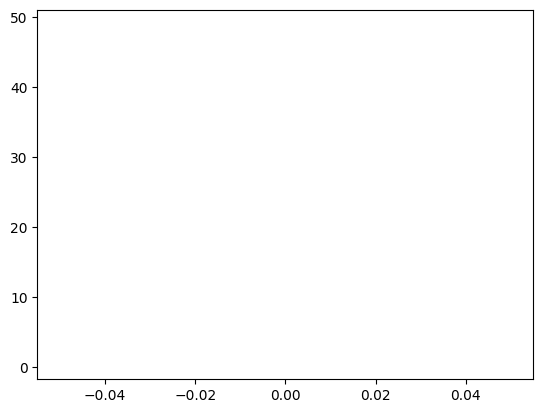

In [ ]:
# jnp.array(vmapped_results['s']).shape
import matplotlib.pyplot as plt

plt.plot(jnp.array(vmapped_results['s']).T[:,:]);

In [ ]:


# --- Example Usage ---
# Assuming you have these variables from your previous run:
vmapped_results = {'U': jnp.array(vmapped_results['U']), 's': jnp.array(vmapped_results['s']), 'V': jnp.array(vmapped_results['V'])}
# embeddings = the original embeddings tensor

reconstructed_output = reconstruct_output_from_svd(vmapped_results, embeddings)

Reconstruction complete.
  Shape of per-token contributions: (427, 2560)
  Shape of final reconstructed output: (2560,)


In [ ]:

argsorted = jnp.argsort(get_logits(reconstructed_output))#[::-1]
# print([tokenizer.decode(argsorted[ii]) for ii in range(18)])
print([tokenizer.decode(argsorted[::-1][ii]) for ii in range(18)])

[' infinity', ',', ';', ' and', '.', ' distance', ' space', ' existence', ' expression', ' reality', ' perfection', ' (', ' infinit', ' infinite', ' representation', ' form', ' eternity', ' emptiness']


In [ ]:
for ii in range(embeddings.shape[1]):
  for sv in range(1):
    uvec = jnp.array(vmapped_results['U'])[-ii,sv,:].squeeze()
    usign = jnp.sign(jnp.inner(reconstructed_output, uvec))
    argsorted = jnp.argsort(usign*get_logits(uvec))#[::-1]
    # print([tokenizer.decode(argsorted[ii]) for ii in range(18)])
    print(ii,sv,vmapped_results['s'][-ii,sv],[tokenizer.decode(argsorted[::-1][jj]) for jj in range(8)],"in=",tokenizer.decode( prompt[ii:ii+1]))#print(ii,"in=",tokenizer.decode( prompt[ii:ii+1]),", ",[tokenizer.decode(argsorted[::-1][jj]) for jj in range(18)])
    # print(ii,"in=",tokenizer.decode( prompt[ii:ii+1]),", ",[tokenizer.decode(argsorted[::-1][jj]) for jj in range(18)])

0 0 11.565586 ['.', ',', ' –', '  ', '…', ' *', '—', ' …'] in= By
1 0 48.636517 [' nothing', ' certainty', ' truth', ' devotion', ' minimum', 'nothing', ' thing', ' Nothing'] in=  this
2 0 17.818209 [' reality', ' knowledge', ' expression', ' existence', ' power', ' unity', ' nature', ' equality'] in=  art
3 0 17.47723 [' expression', ' existence', ' reality', ' knowledge', ' unity', ' organization', ' structure', ' equality'] in=  you
4 0 11.216746 [' existence', ' expression', ' reality', ' structure', ' space', ' representation', ' nature', ' creation'] in=  may
5 0 7.4371543 [' existence', ' reality', ' expression', ' space', ' structure', ' nature', ' representation', ' creation'] in=  contemplate
6 0 7.165049 [' existence', ' reality', ' expression', ' space', '.', ' structure', ' creation', ' nature'] in=  the
7 0 6.324123 [' room', ' rooms', ' Room', ' Rooms', 'Room', 'room', ' ROOM', 'Rooms'] in=  variations
8 0 6.078444 [' reality', ' space', ' existence', ' architecture', ' 

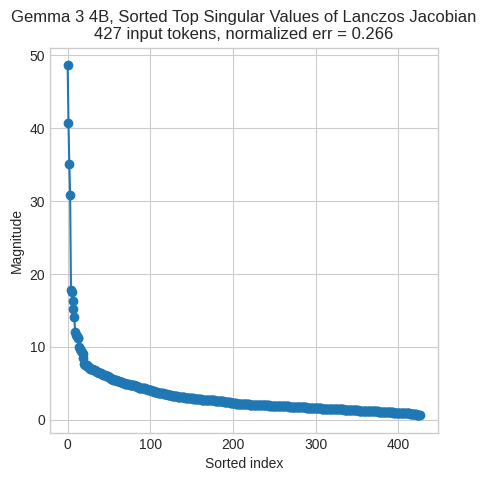

In [ ]:
plt.figure(figsize=[5,5])
plt.plot(sorted(jnp.array(vmapped_results['s'])[::])[::-1],'-o')
plt.grid()
plt.xlabel("Sorted index")
plt.ylabel("Magnitude")
plt.grid()
# plt.title("")

plt.title(f'Gemma 3 4B, Sorted Top Singular Values of Lanczos Jacobian\n427 input tokens, normalized err = {np.std(recondiff):1.3f}')

plt.savefig('gemma_3_4b_lanczos_427_sv.pdf')

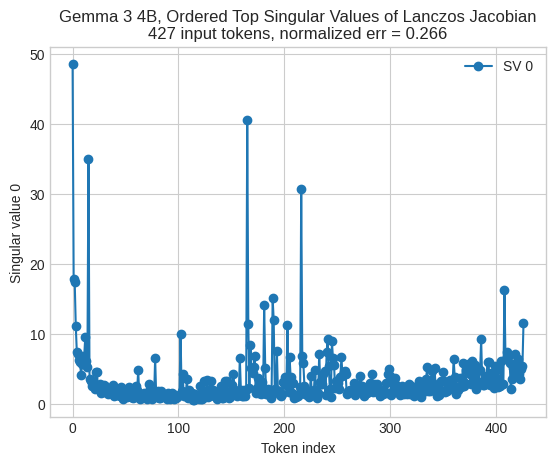

In [ ]:
plt.plot(jnp.array(vmapped_results['s'])[::-1],'-o')
# plt.plot(jnp.array(vmapped_results['s']).T[1,:],'-o')
# plt.plot(jnp.array(vmapped_results['s']).T[2,:],'-o')
plt.grid()
plt.legend(["SV 0"])#, "SV 1"])
plt.xlabel("Token index")
plt.ylabel("Singular value 0")

plt.title(f'Gemma 3 4B, Ordered Top Singular Values of Lanczos Jacobian\n427 input tokens, normalized err = {np.std(recondiff):1.3f}')
plt.grid()
plt.savefig('gemma_3_4b_lanczos_427_sv_ordered.pdf')

In [ ]:


# --- Example Usage ---
# Assuming you have these variables from your previous run:
vmapped_results = {'U': jnp.array(vmapped_results['U']), 's': jnp.array(vmapped_results['s']), 'V': jnp.array(vmapped_results['V'])}
# embeddings = the original embeddings tensor

reconstructed_output = reconstruct_output_from_svd(vmapped_results, embeddings)

Reconstruction complete.
  Shape of per-token contributions: (427, 2560)
  Shape of final reconstructed output: (2560,)


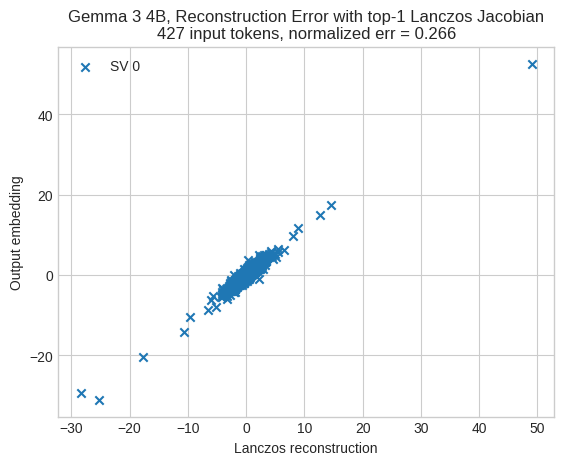

In [ ]:
plt.scatter(reconstructed_output, output_from_embeddings[2],marker='x')
plt.grid()

plt.legend(["SV 0"])#, "SV 1"])
plt.xlabel("Lanczos reconstruction")
plt.ylabel("Output embedding")
plt.grid()
# plt.savefig('gemma_3_4b_lanczos_427_sv_ordered.pdf')

plt.title(f'Gemma 3 4B, Reconstruction Error with top-1 Lanczos Jacobian\n427 input tokens, normalized err = {np.std(recondiff):1.3f}')
plt.savefig('gemma_3_4b_lanczos_427_recon_scatter.pdf')

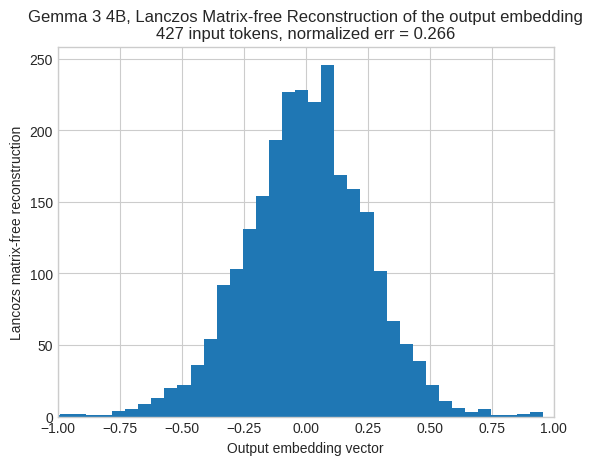

In [ ]:
plt.hist(recondiff[0],bins=80)

# plt.grid()
plt.xlim([-1,1])
plt.xlabel('Output embedding vector')
plt.ylabel('Lancozs matrix-free reconstruction')
plt.title(f'Gemma 3 4B, Lanczos Matrix-free Reconstruction of the output embedding\n427 input tokens, normalized err = {np.std(recondiff):1.3f}')

plt.savefig('gemma_3_4b_lanczos_427_hist2.pdf')